# Handling Missing Data: Imputation

[![Created by JPabloCabrera](https://img.shields.io/badge/Crated%20by-%40JPabloCabrera-blue?&style=for-the-badge&logo=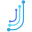)](https://github.com/JPabloCabrera)



## Workspace setup

```bash
pip install --upgrade pip
```

```bash
pip install pyjanitor matplotlib missingno nhanes pandas scipy seaborn session-info sklearn statsmodels upsetplot
```

or 

```bash
pip install -r requirements.txt
```

## Import Libraries

In [2]:
import janitor
import matplotlib.pyplot as plt
import missingno
import nhanes.load
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import session_info
import sklearn.compose
import sklearn.impute
import sklearn.preprocessing
import statsmodels.api as sm
import statsmodels.datasets
import statsmodels.formula.api as smf

from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import BayesianRidge, Ridge
from sklearn.neighbors import KNeighborsRegressor
from statsmodels.graphics.mosaicplot import mosaic

## Import custom functions

In [3]:
run pandas-missing-extension.ipynb

## Configure the overall appearance of the project's charts

In [4]:
%matplotlib inline

sns.set(
    rc={
        "figure.figsize": (8, 6)
    }
)

sns.set_style("whitegrid")

## The problem of working with missing values

In [5]:
airquality_df = (
    sm.datasets.get_rdataset("airquality")
    .data
    .clean_names(
        case_type = "snake"
    )
    .add_column("year", 1973)
    .assign(
        date = lambda df:pd.to_datetime(df[["year", "month", "day"]])
    )
    .sort_values(by = "date")
    .set_index("date")
)

airquality_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 1973-05-01 to 1973-09-30
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ozone    116 non-null    float64
 1   solar_r  146 non-null    float64
 2   wind     153 non-null    float64
 3   temp     153 non-null    int64  
 4   month    153 non-null    int64  
 5   day      153 non-null    int64  
 6   year     153 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 9.6 KB


In [6]:
airquality_df

ozone  solar_r  wind  temp  month  day  year
date                                                    
1973-05-01   41.0    190.0   7.4    67      5    1  1973
1973-05-02   36.0    118.0   8.0    72      5    2  1973
1973-05-03   12.0    149.0  12.6    74      5    3  1973
1973-05-04   18.0    313.0  11.5    62      5    4  1973
1973-05-05    NaN      NaN  14.3    56      5    5  1973
...           ...      ...   ...   ...    ...  ...   ...
1973-09-26   30.0    193.0   6.9    70      9   26  1973
1973-09-27    NaN    145.0  13.2    77      9   27  1973
1973-09-28   14.0    191.0  14.3    75      9   28  1973
1973-09-29   18.0    131.0   8.0    76      9   29  1973
1973-09-30   20.0    223.0  11.5    68      9   30  1973

[153 rows x 7 columns]

In [7]:
(
    smf.ols(
        formula = "temp ~ ozone",
        data = airquality_df
    )
    .fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

In [8]:
(
    smf.ols(
        formula = "temp ~ ozone + month + wind + month",
        data = airquality_df
    ).fit()
    .summary()
    .tables[0]
)

<class 'statsmodels.iolib.table.SimpleTable'>

### Survivor data

In [9]:
survival_df = sm.datasets.get_rdataset("flchain", "survival").data

In [10]:
survival_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7874 entries, 0 to 7873
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         7874 non-null   int64  
 1   sex         7874 non-null   object 
 2   sample.yr   7874 non-null   int64  
 3   kappa       7874 non-null   float64
 4   lambda      7874 non-null   float64
 5   flc.grp     7874 non-null   int64  
 6   creatinine  6524 non-null   float64
 7   mgus        7874 non-null   int64  
 8   futime      7874 non-null   int64  
 9   death       7874 non-null   int64  
 10  chapter     2169 non-null   object 
dtypes: float64(3), int64(6), object(2)
memory usage: 676.8+ KB


Some models are adjusted using variables with missing values as predictors.

In [11]:
(
    smf.ols(
        formula="death ~ kappa + creatinine + futime + sex + age + chapter" ,
        data = survival_df
    ).fit()
    .summary()
    .tables[0]
)

/home/jose94pablo/anaconda3/envs/imputation/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1736: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


<class 'statsmodels.iolib.table.SimpleTable'>

## Preparing Data: _National Health and Nutrition Examination Survey_

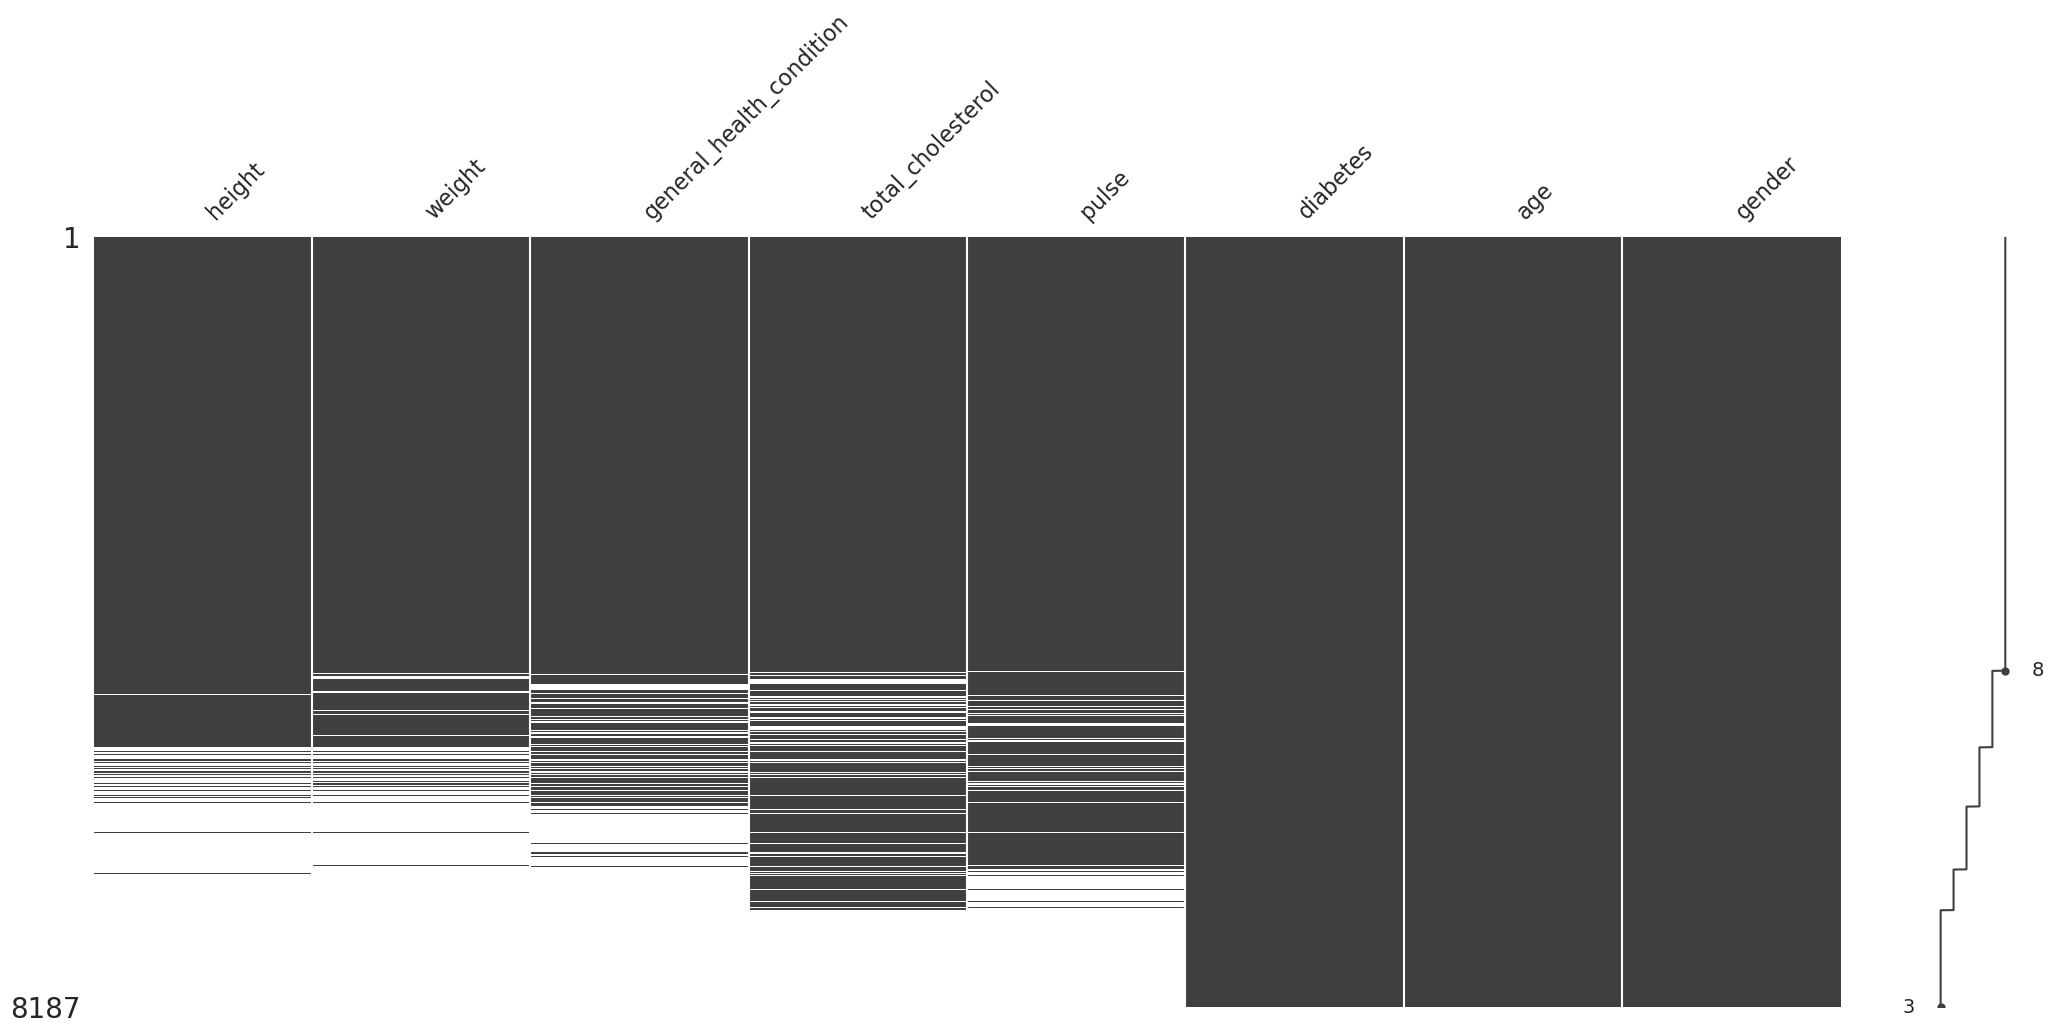

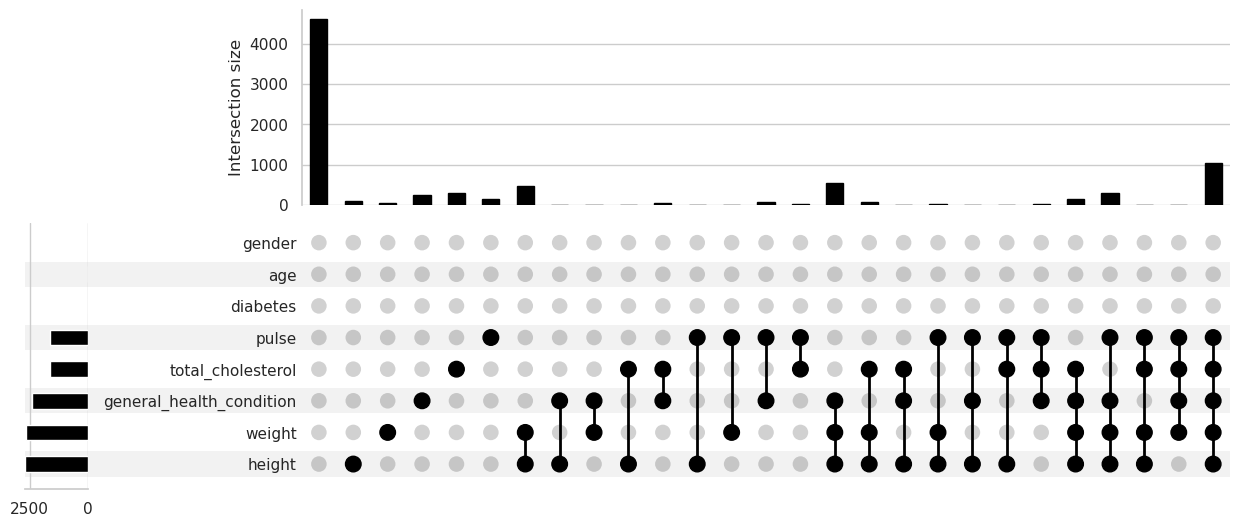

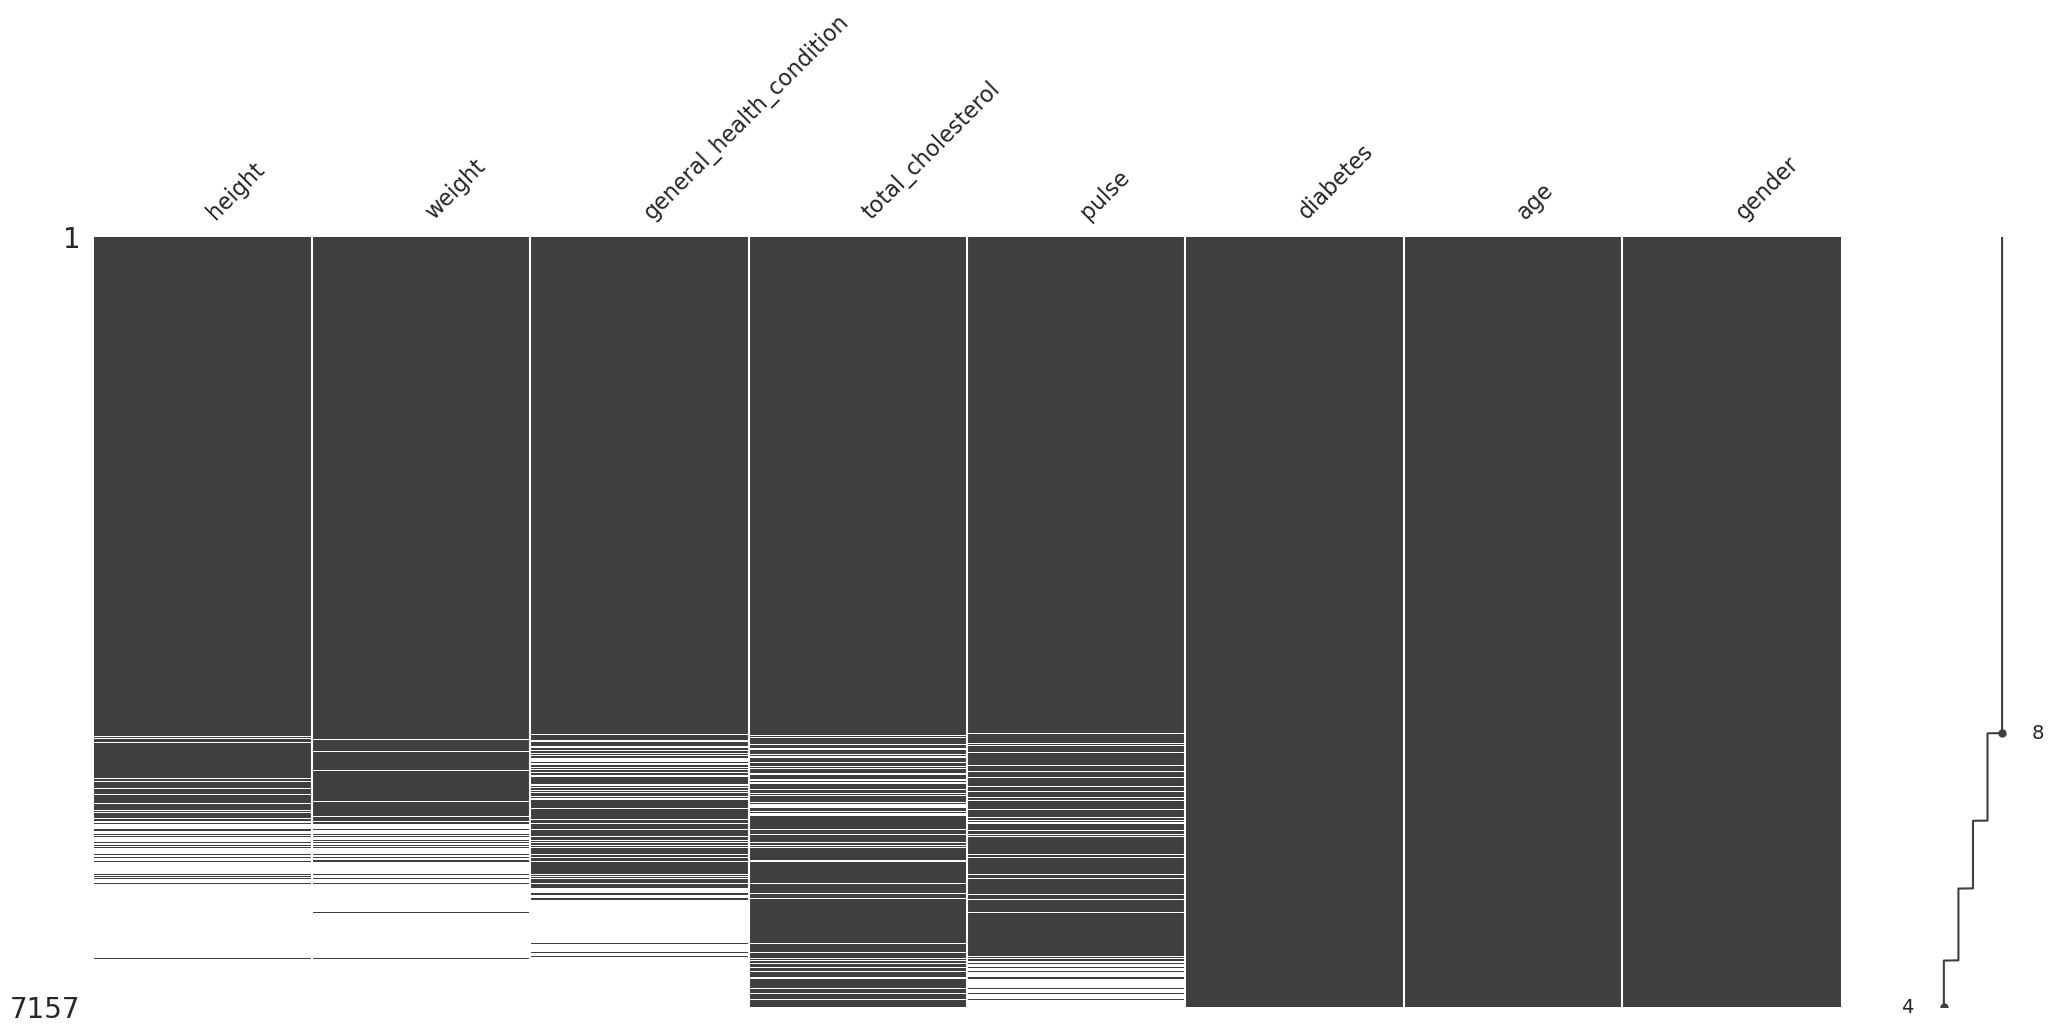

In [12]:
%run download-data-and-load-it.ipynb

## Evaluation of the missing values mechanism through t-test

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Information</b>
    <p>
        <code>two-sided</code>: the <b>means</b> of the underlying distributions of the samples are <b>unequal</b>.<br>
        <code>less</code>: the <b>mean</b> of the underlying distribution of the <b>first</b> sample is <b>less</b> than the mean of the distribution of the <b>second</b> sample.<br>
        <code>greater</code>: the <b>mean</b> of the underlying distribution of the <b>first</b> sample is <b>greater</b> than the mean of the distribution of the <b>second</b> sample.<br>
    </p>
</div>


In [13]:
famela_weight, male_weight = (
    nhanes_df
    .select_columns("gender", "weight")
    .transform_column(
        "weight",
        lambda x: x.isna(),
        elementwise = False
    )
    .groupby("gender")
    .weight
    .pipe(lambda df: (
        df.get_group("Female"),
        df.get_group("Male")
    ))
)

scipy.stats.ttest_ind(
    a = famela_weight,
    b = male_weight,
    alternative = "two-sided"
)


Ttest_indResult(statistic=-0.3621032192538131, pvalue=0.7172855918077239)

In [14]:
# Z-Test Validation.

import numpy as np
from scipy.stats import norm

# Example data: weights of females and males
female_weight
male_weight

# Calculate mean and standard deviation for each group
mean_female = np.mean(female_weight)
std_female = np.std(female_weight, ddof=1)  # Using ddof=1 to calculate the sample standard deviation

mean_male = np.mean(male_weight)
std_male = np.std(male_weight, ddof=1)

# Calculate the Z-statistic for group comparison
z_statistic = (mean_female - mean_male) / np.sqrt((std_female**2 / len(female_weight)) + (std_male**2 / len(male_weight)))

# Calculate the p-value for the Z-test
p_value = 2 * (1 - norm.cdf(np.abs(z_statistic)))

print("Z-statistic:", z_statistic)
print("p-value:", p_value)



Estadístico Z: -0.3620535773320973
Valor p (p-value): 0.7173119934814769


## Expand your toolkit for exploring missing values

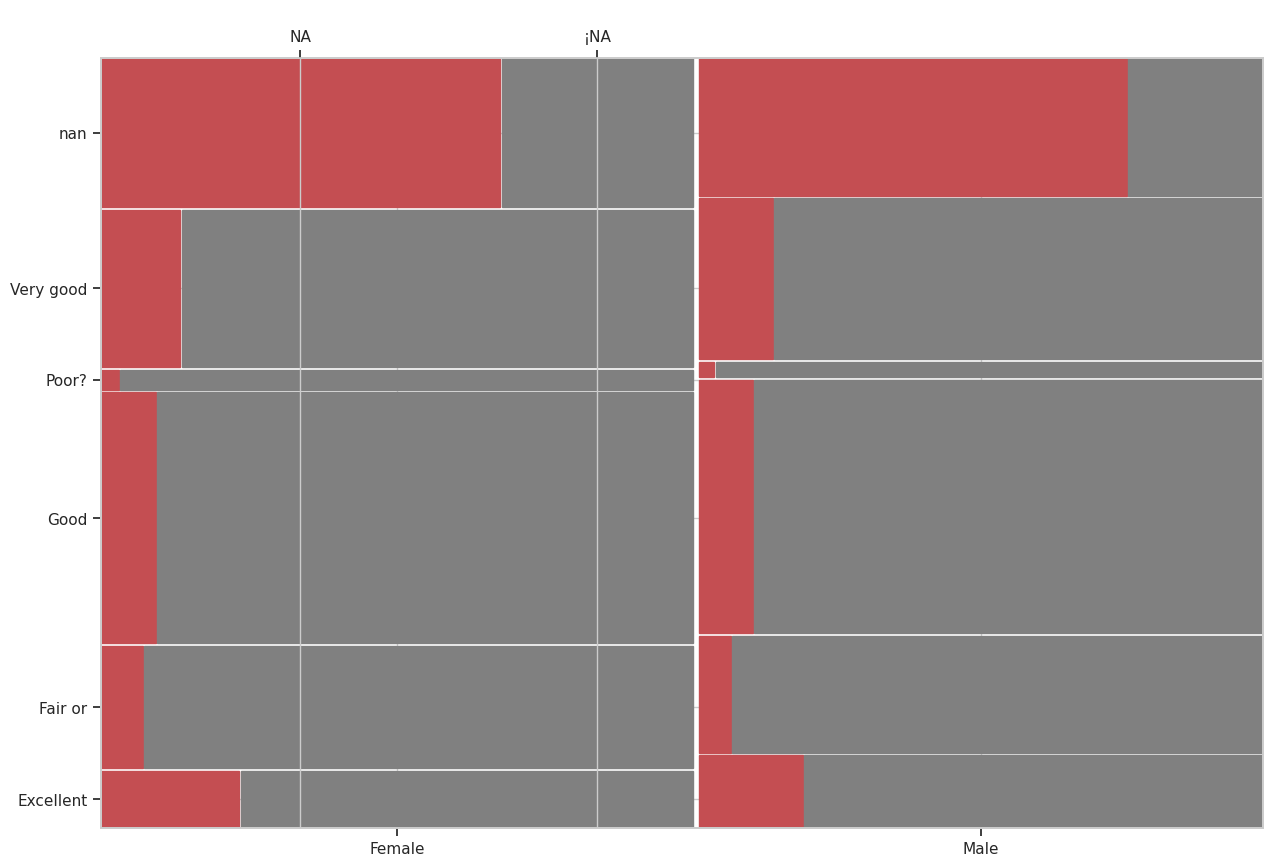

In [15]:
fig, ax = plt.subplots(figsize = (15, 10))

(
    nhanes_df
    .select_columns("weight", "general_health_condition", "gender")
    .assign(
        weight = lambda df : df.weight.isna().replace([True, False], ["NA", "¡NA"])
    )
    .groupby(
        ["gender", "general_health_condition", "weight"],
        dropna = False,
        as_index = True
    )
    .size()
    .pipe(
        lambda df : mosaic(
            data = df,
            properties = lambda key : {"color":"r" if "NA" in key else "gray"},
            horizontal = True,
            axes_label = True,
            title = " ",
            
            labelizer = lambda key: " ",
            ax = ax
        )
    )

) ;

In [16]:

def missing_mosaic_plot(
        self,
        categorical_variable_1: str,
        categorical_variable_2: str,
        missing_data_variable: str,
):

    fig, ax = plt.subplots(figsize = (15, 10))

    (
        self
        .select_columns(f"{missing_data_variable}", f"{categorical_variable_1}", f"{categorical_variable_2}")
        .assign(
            weight = lambda df : df[f"{missing_data_variable}"].isna().replace([True, False], ["NA", "¡NA"])
        )
        .groupby(
            [f"{categorical_variable_1}", f"{categorical_variable_2}", f"{missing_data_variable}"],
            dropna = False,
            as_index = True
        )
        .size()
        .pipe(
            lambda df : mosaic(
                data = df,
                properties = lambda key : {"color":"r" if "NA" in key else "gray"},
                horizontal = True,
                axes_label = True,
                title = " ",
                
                labelizer = lambda key: " ",
                ax = ax
            )
        )

    ) ;

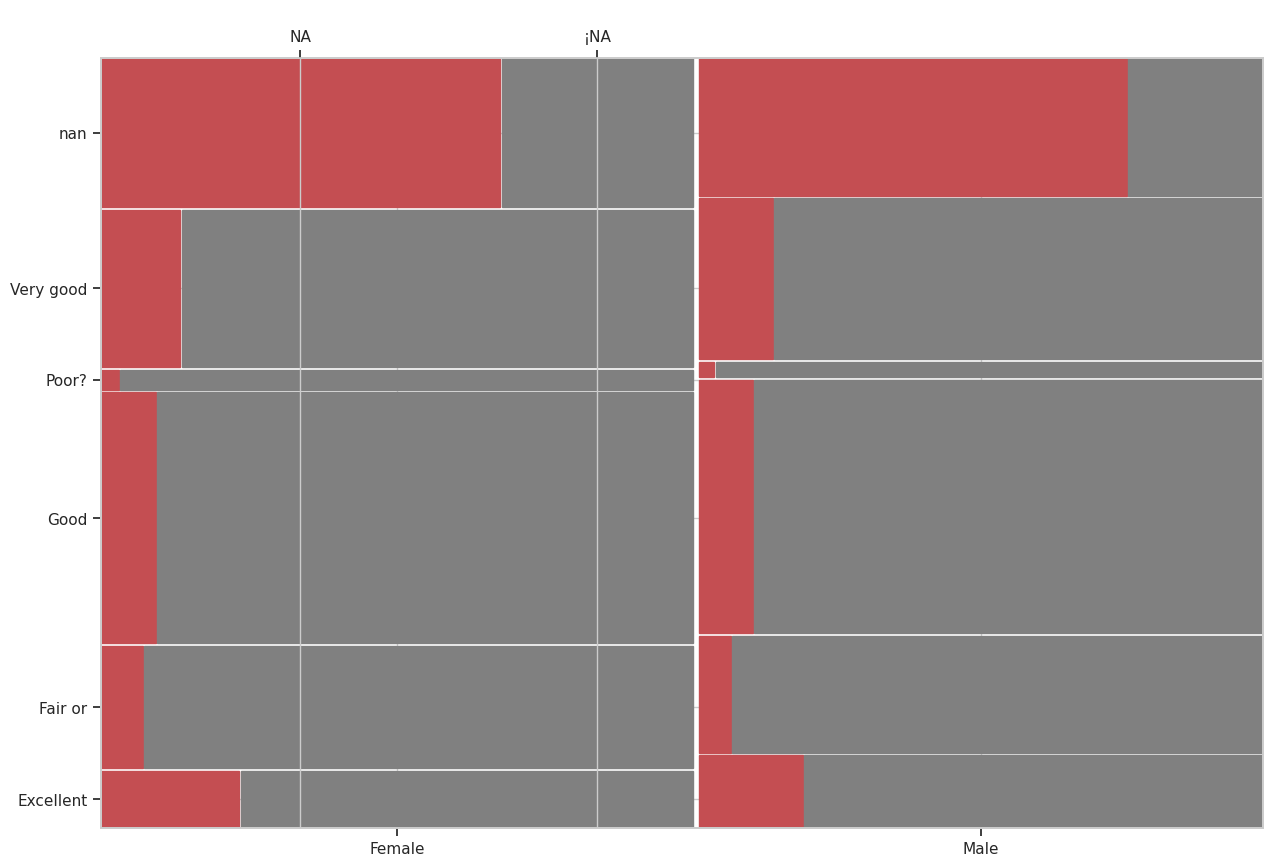

In [17]:
missing_mosaic_plot(self = nhanes_df, categorical_variable_1="gender", categorical_variable_2= "general_health_condition", missing_data_variable= "weight")

## Handling categorical variables for missing value imputation

In [18]:
nhanes_transformed_df = nhanes_df.copy(deep=True)

### Ordinal encoding

<div class="alert alert-info">
    <b style="font-size: 1.5em;">📘 Information</b>
    <p>
    Ordinal encoding <b>involves</b> mapping each unique label (category) to an integer value. Ordinal encoding is also known as integer encoding.
    </p>
</div>


#### Problem

Given a dataset with two features, we will find the unique values for each feature and transform them using ordinal encoding.

In [19]:
encoder = sklearn.preprocessing.OrdinalEncoder()

X = [["Male"], ["Female"], ["Female"]]
X

[['Male'], ['Female'], ['Female']]

In [20]:
encoder.fit_transform(X)

array([[1.],
       [0.],
       [0.]])

In [21]:
encoder.categories_

[array(['Female', 'Male'], dtype=object)]

In [22]:
encoder.inverse_transform([[1],[0],[0]])

array([['Male'],
       ['Female'],
       ['Female']], dtype=object)

#### Applying ordinal encoding to all your categorical variables

In [23]:
categorical_columns = nhanes_df.select_dtypes(include = [object, "category"]).columns

In [24]:
categorical_transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OrdinalEncoder(), categorical_columns),
    remainder='passthrough'
)

In [25]:
nhanes_transformed_df = (
    pd.DataFrame(
        categorical_transformer.fit_transform(nhanes_df),
        columns = categorical_transformer.get_feature_names_out(),
        index = nhanes_df.index
    )
    .rename_columns(
        function = lambda x : x.removeprefix("ordinalencoder__")
    )
    .rename_columns(
        function = lambda x : x.removeprefix("remainder__")
    )
)

nhanes_transformed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [26]:
gender_encoder = sklearn.preprocessing.OrdinalEncoder()

gender_values = (
    nhanes_df
    .gender
    .values
    .reshape(-1, 1)
)

(
    gender_encoder
    .fit_transform(
        X = gender_values
    )
    .squeeze()
)

(
    nhanes_df.gender.unique(),
    nhanes_transformed_df.gender.unique(),
    gender_encoder.categories_
)

(array(['Female', 'Male'], dtype=object),
 array([0., 1.]),
 [array(['Female', 'Male'], dtype=object)])

### _One Hot Encoding_

In [27]:
nhanes_transformed_df2 = nhanes_df.copy(deep = True)

### `pandas.get_dummies()` vs `skelearn.preprocessing.OneHotEncoder()`

#### `pandas.get_dummies()`

In [28]:
(
    nhanes_transformed_df2
    .select_columns("general_health_condition")
    .head(10)
    .pipe(pd.get_dummies)
)

general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                       
93705.0                                 0                              1   
93706.0                                 0                              0   
93707.0                                 0                              1   
93709.0                                 0                              0   
93711.0                                 0                              0   
93712.0                                 0                              1   
93713.0                                 0                              0   
93714.0                                 0                              1   
93715.0                                 1                              0   
93716.0                                 0                              0   

         general_health_condition_Very good  
SEQN                                         
93705.0                                   0  
93706.0                                   1  
93707.0                                   0  
93709.0                                   0  
93711.0                                   1  
93712.0                                   0  
93713.0                                   1  
93714.0                                   0  
93715.0                                   0  
93716.0                                   1

#### `skelearn.preprocessing.OneHotEncoder()`

In [29]:
transformer = sklearn.compose.make_column_transformer(
    (sklearn.preprocessing.OneHotEncoder(), ["general_health_condition"]),
    (sklearn.preprocessing.OrdinalEncoder(), ["gender"]),
    remainder='passthrough'
)
transformer

ColumnTransformer(remainder='passthrough',
                  transformers=[('onehotencoder', OneHotEncoder(),
                                 ['general_health_condition']),
                                ('ordinalencoder', OrdinalEncoder(),
                                 ['gender'])])

In [30]:
nhanes_transformed_df2 = (
    pd.DataFrame(        
        transformer.fit_transform(nhanes_df),
        columns = transformer.get_feature_names_out(),
        index = nhanes_df.index
        )
        .rename_columns(
           function = lambda x: x.removeprefix("onehotencoder__")
        )
        .rename_columns(
            function = lambda x : x.removeprefix("ordinalencoder__")
        )
        .rename_columns(
            function = lambda x : x.removeprefix("remainder__")
        )
)

nhanes_transformed_df2

general_health_condition_Excellent  \
SEQN                                           
93705.0                                  0.0   
93706.0                                  0.0   
93707.0                                  0.0   
93709.0                                  0.0   
93711.0                                  0.0   
...                                      ...   
102949.0                                 1.0   
102953.0                                 0.0   
102954.0                                 0.0   
102955.0                                 0.0   
102956.0                                 0.0   

          general_health_condition_Fair or  general_health_condition_Good  \
SEQN                                                                        
93705.0                                0.0                            1.0   
93706.0                                0.0                            0.0   
93707.0                                0.0                            1.0   
93709.0                                0.0                            0.0   
93711.0                                0.0                            0.0   
...                                    ...                            ...   
102949.0                               0.0                            0.0   
102953.0                               1.0                            0.0   
102954.0                               0.0                            1.0   
102955.0                               0.0                            0.0   
102956.0                               0.0                            1.0   

          general_health_condition_Poor?  general_health_condition_Very good  \
SEQN                                                                           
93705.0                              0.0                                 0.0   
93706.0                              0.0                                 1.0   
93707.0                              0.0                                 0.0   
93709.0                              0.0                                 0.0   
93711.0                              0.0                                 1.0   
...                                  ...                                 ...   
102949.0                             0.0                                 0.0   
102953.0                             0.0                                 0.0   
102954.0                             0.0                                 0.0   
102955.0                             0.0                                 1.0   
102956.0                             0.0                                 0.0   

          general_health_condition_nan  gender  height  weight  \
SEQN                                                             
93705.0                            0.0     0.0    63.0   165.0   
93706.0                            0.0     1.0    68.0   145.0   
93707.0                            0.0     1.0     NaN     NaN   
93709.0                            1.0     0.0    62.0   200.0   
93711.0                            0.0     1.0    69.0   142.0   
...                                ...     ...     ...     ...   
102949.0                           0.0     1.0    72.0   180.0   
102953.0                           0.0     1.0    65.0   218.0   
102954.0                           0.0     0.0    66.0   150.0   
102955.0                           0.0     0.0     NaN     NaN   
102956.0                           0.0     1.0    69.0   250.0   

          total_cholesterol  pulse  diabetes   age  
SEQN                                                
93705.0               157.0   52.0       0.0  66.0  
93706.0               148.0   82.0       0.0  18.0  
93707.0               189.0  100.0       0.0  13.0  
93709.0               176.0   74.0       0.0  75.0  
93711.0               238.0   62.0       0.0  56.0  
...                     ...    ...       ...   ...  
102949.0              201.0   96.0       0.0  33.0  
102953

In [31]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .categories_
)

[array(['Excellent', 'Fair or', 'Good', 'Poor?', 'Very good', nan],
       dtype=object)]

In [32]:
(
    transformer
    .named_transformers_
    .get("onehotencoder")
    .inverse_transform(
        X = [[0,0,0,0,1,0]]
    )
)

array([['Very good']], dtype=object)

## Single value imputation (mean, median, mode)

In [33]:
(
    nhanes_df
    #janitor
    .transform_column(
        "height",
        lambda x : x.fillna(x.mean()),
        elementwise = False
    )
)

height  weight general_health_condition  total_cholesterol  pulse  \
SEQN                                                                            
93705.0   63.00000   165.0                     Good              157.0   52.0   
93706.0   68.00000   145.0                Very good              148.0   82.0   
93707.0   66.25656     NaN                     Good              189.0  100.0   
93709.0   62.00000   200.0                      NaN              176.0   74.0   
93711.0   69.00000   142.0                Very good              238.0   62.0   
...            ...     ...                      ...                ...    ...   
102949.0  72.00000   180.0                Excellent              201.0   96.0   
102953.0  65.00000   218.0                  Fair or              182.0   78.0   
102954.0  66.00000   150.0                     Good              172.0   78.0   
102955.0  66.25656     NaN                Very good              150.0   74.0   
102956.0  69.00000   250.0                     Good              163.0   76.0   

          diabetes   age  gender  
SEQN                              
93705.0          0  66.0  Female  
93706.0          0  18.0    Male  
93707.0          0  13.0    Male  
93709.0          0  75.0  Female  
93711.0          0  56.0    Male  
...            ...   ...     ...  
102949.0         0  33.0    Male  
102953.0         0  42.0    Male  
102954.0         0  41.0  Female  
102955.0         0  14.0  Female  
102956.0         0  38.0    Male  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='height', ylabel='weight'>

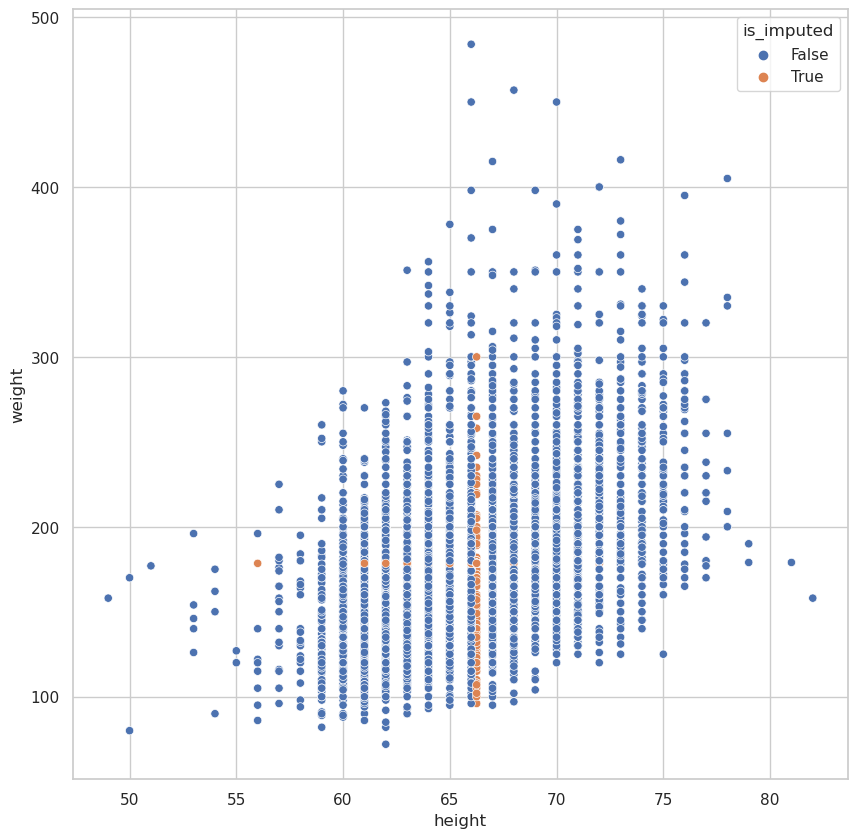

In [34]:
plt.figure(figsize= [10,10])

(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight"
    )
)

#### Placing the marginal distributions on the sides

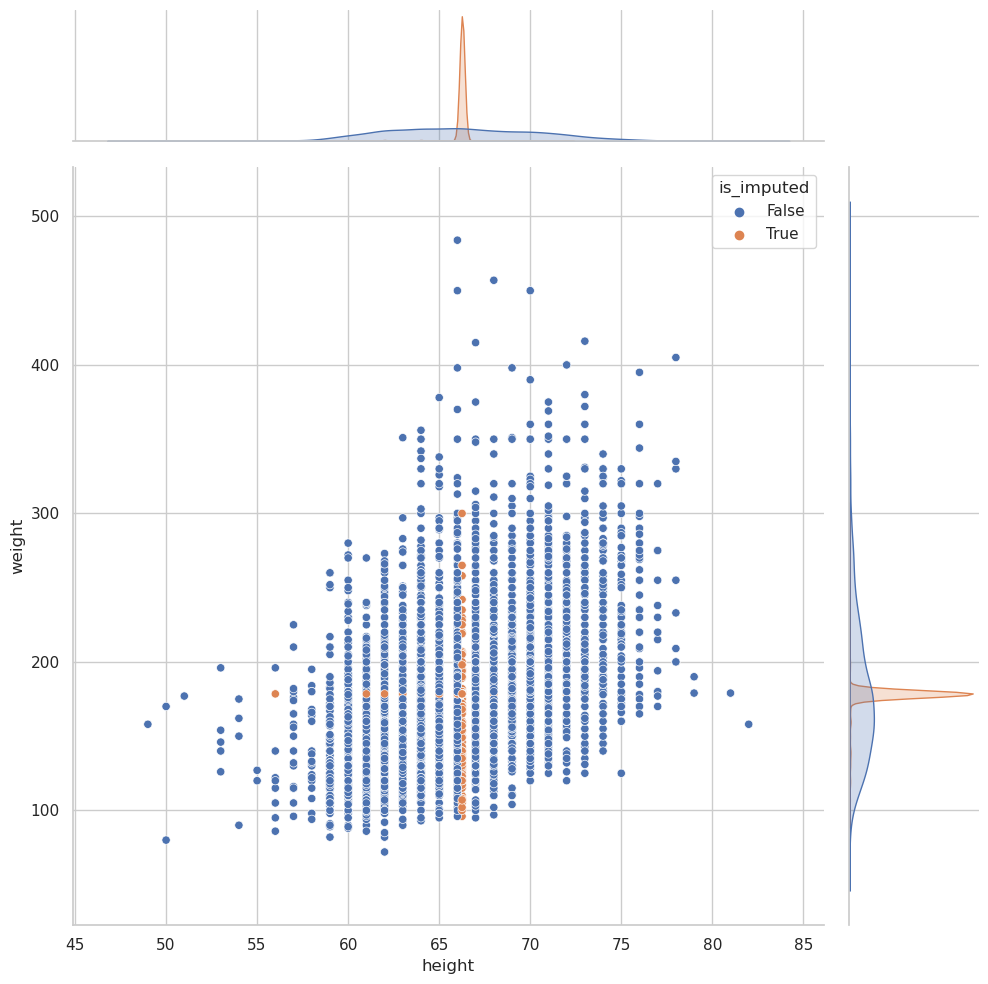

In [35]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mean()),
        weight = lambda df: df.weight.fillna(value = df.weight.mean())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        height = 10
    )
)

#### MODE

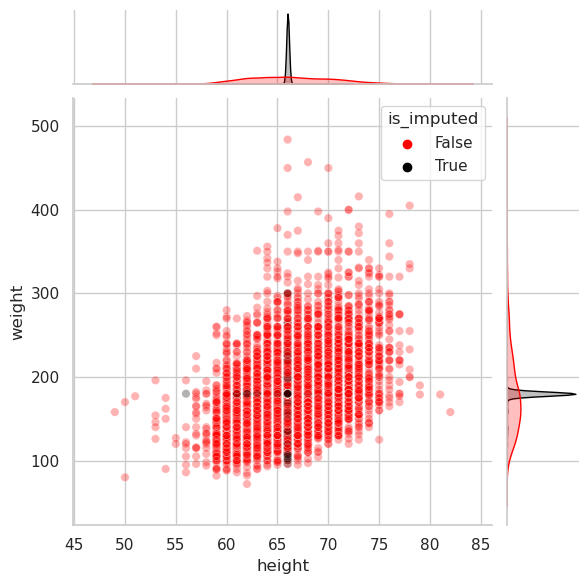

In [36]:

my_colors = {
    False: "red",
    True: "black",
}

size_mapping = {
    False: 20,
    True: 100
}


(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()[0]),
        weight = lambda df: df.weight.fillna(value = df.weight.mode()[0])
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        #height = 10,
        alpha = 0.3,
        palette=my_colors,
        sizes = size_mapping
        
    )
)

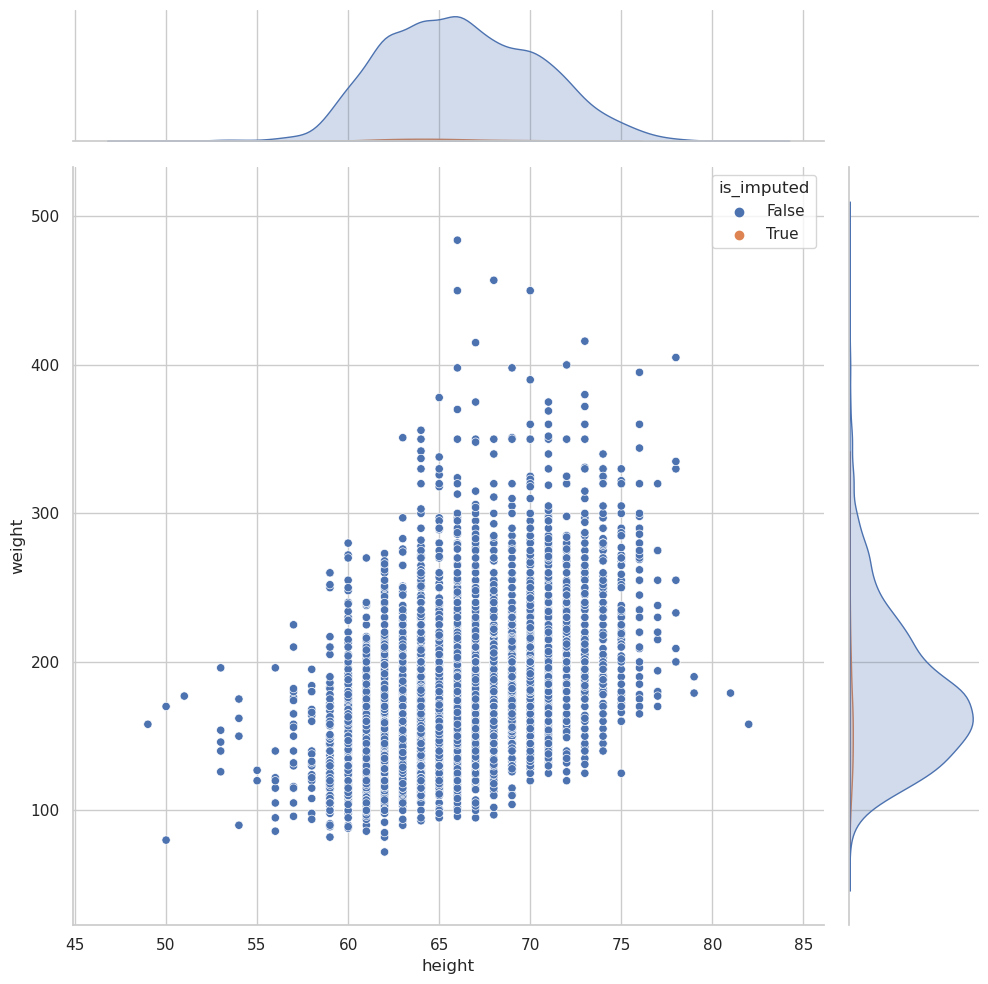

In [37]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        height = 10,
    )
)

#### Median

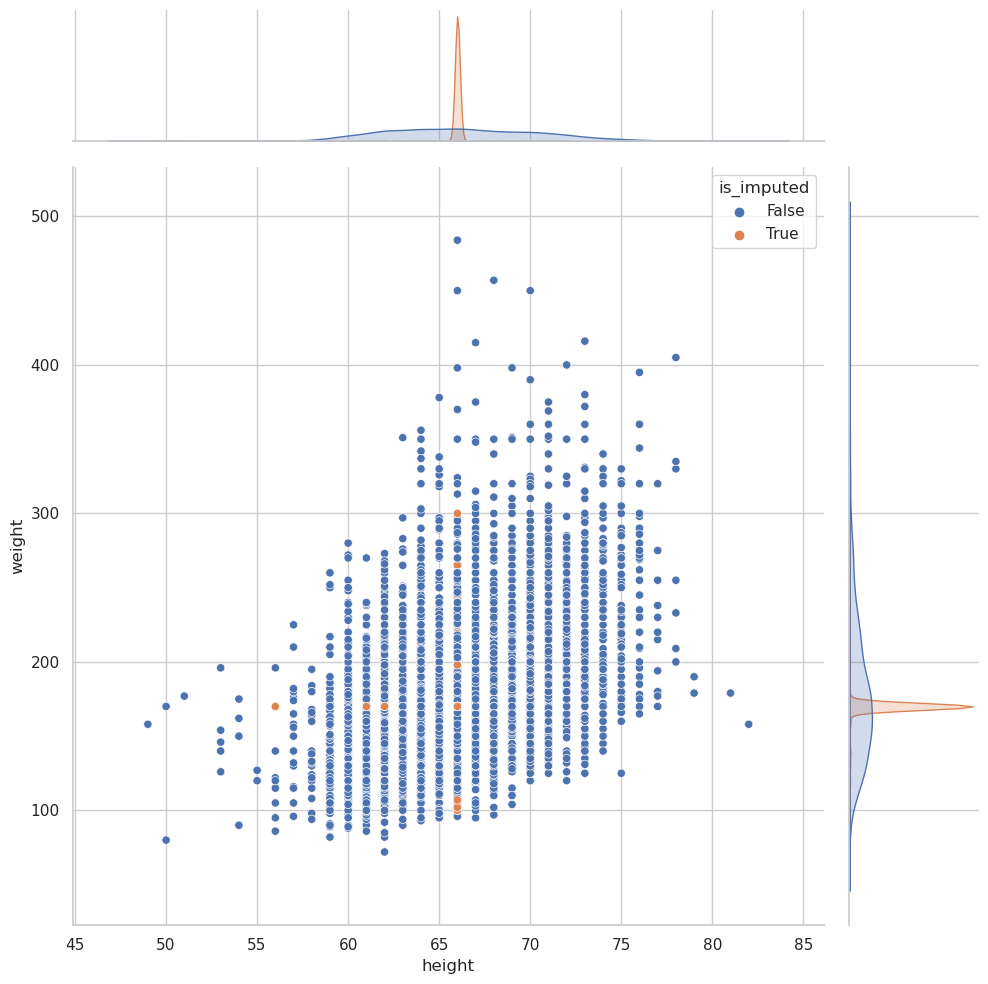

In [38]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.median()),
        weight = lambda df: df.weight.fillna(value = df.weight.median())
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        height = 10,
    )
)

In [39]:
(
    nhanes_df
    .select_columns("height", "weight")
    .missing.bind_shadow_matrix(True, False, suffix = "_imp")
    .assign(
        height = lambda df: df.height.fillna(value = df.height.mode()),
        weight = lambda df: df.weight.fillna(value = df.weight.mode())
    )
)

height  weight  height_imp  weight_imp
SEQN                                            
93705.0     63.0   165.0       False       False
93706.0     68.0   145.0       False       False
93707.0      NaN     NaN        True        True
93709.0     62.0   200.0       False       False
93711.0     69.0   142.0       False       False
...          ...     ...         ...         ...
102949.0    72.0   180.0       False       False
102953.0    65.0   218.0       False       False
102954.0    66.0   150.0       False       False
102955.0     NaN     NaN        True        True
102956.0    69.0   250.0       False       False

[7157 rows x 4 columns]

In [40]:
nhanes_df.height.mode()

0    66.0
Name: height, dtype: float64

## Backfill imputation and forward fill imputation

### `fillna()` vs `ffill()` o `bfill()`

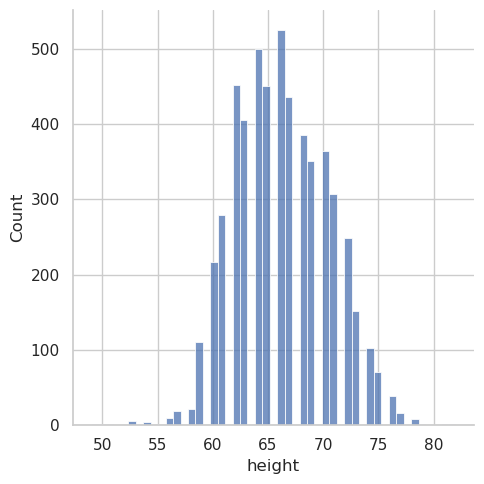

In [41]:
sns.displot(data =(
    nhanes_df
    ), x = "height"
)

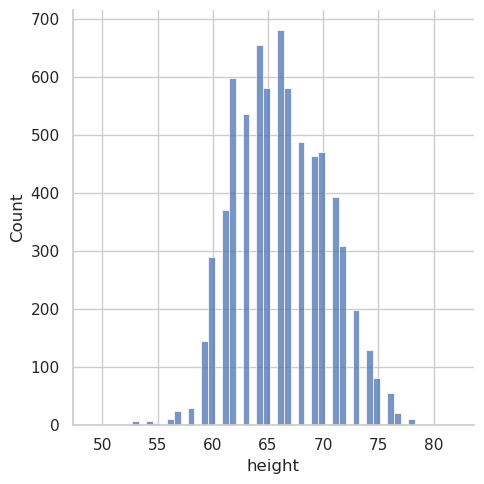

In [42]:
sns.displot(data =(
    nhanes_df
    .select_columns("height","weight")
    .fillna(method = "ffill")
    ), x = "height"
)

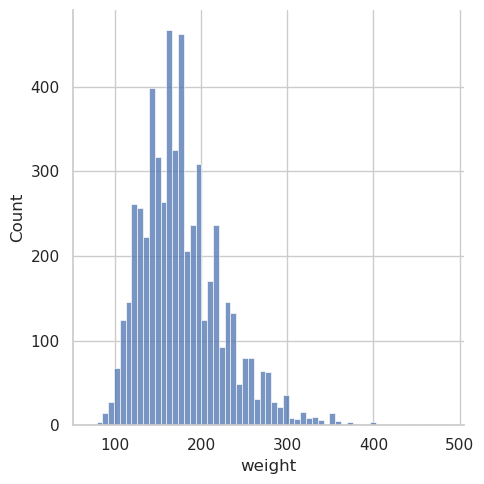

In [43]:
sns.displot(data =(
    nhanes_df
    ), x = "weight"
)

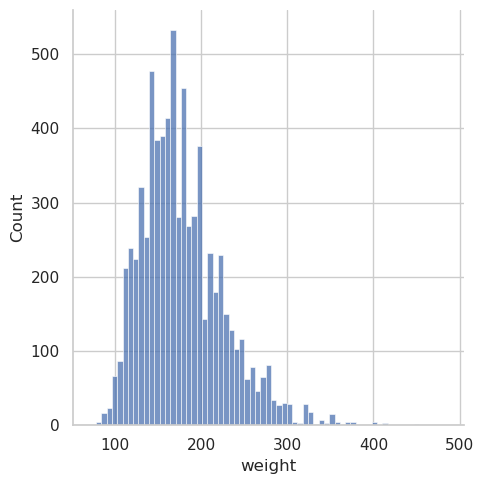

In [44]:
(
    nhanes_df
    .select_columns("height","weight")
    .fillna(method = "ffill")
    .pipe(
        lambda df : sns.displot(data= df, x = "weight")
    )
)

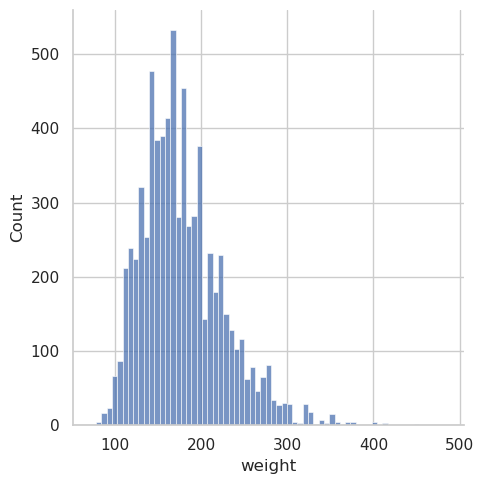

In [45]:
(
    nhanes_df
    .select_columns("height","weight")
    #.fillna(method = "ffill")
    .ffill()
    .pipe(
        lambda df: sns.displot(data = df, x = "weight")
    )
)

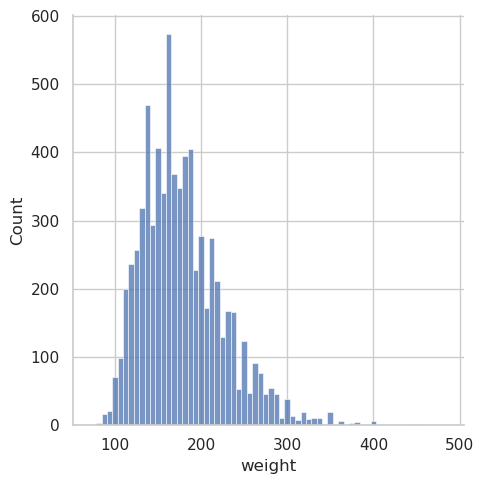

In [46]:
(
    nhanes_df
    .select_columns("height","weight")
    #.fillna(method = "bfill")
    .bfill()
    .pipe(
        lambda df: sns.displot(data = df, x = "weight")
    )
)

#### Imputing values using `ffill()` or `bfill()`

> Domain-wise imputation and imputation through correlated variables

In [47]:
(
    nhanes_df
    .select_columns("height","weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
)

height  weight  gender  diabetes general_health_condition
SEQN                                                              
94421.0    56.0   115.0  Female         0                Excellent
94187.0    59.0   130.0  Female         0                Excellent
95289.0    59.0   162.0  Female         0                Excellent
97967.0    59.0   130.0  Female         0                Excellent
99125.0    59.0   105.0  Female         0                Excellent
...         ...     ...     ...       ...                      ...
96561.0    74.0   290.0    Male         1                      NaN
96954.0     NaN   175.0    Male         1                      NaN
97267.0     NaN   175.0    Male         1                      NaN
97856.0     NaN   175.0    Male         1                      NaN
98317.0     NaN   175.0    Male         1                      NaN

[7157 rows x 5 columns]

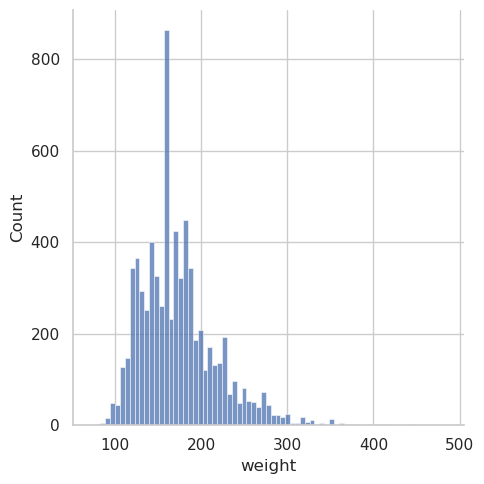

In [48]:
(nhanes_df
    .select_columns("height","weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by = ["gender", "diabetes", "general_health_condition", "height"],
        ascending = True
    )
    .transform_column(
        "weight",
        lambda x: x.ffill(),
        elementwise = False
    )
    .pipe( 
        lambda df : sns.displot(data = df, x = "weight")
    )
)

#### Using the groupby method of pandas

In [50]:
result_df = (
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender', 'diabetes', 'general_health_condition', 'weight'],
        ascending=True
    )
    .groupby(["gender", "diabetes", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
)

result_df

<ipython-input-50-9be4e8173449>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nhanes_df


height  weight  gender  diabetes general_health_condition
SEQN                                                               
94195.0     63.0    90.0  Female         0                Excellent
95793.0     61.0    96.0  Female         0                Excellent
101420.0    59.0    98.0  Female         0                Excellent
94148.0     65.0   100.0  Female         0                Excellent
102062.0    62.0   100.0  Female         0                Excellent
...          ...     ...     ...       ...                      ...
96561.0     74.0   290.0    Male         1                      NaN
96869.0     72.0   298.0    Male         1                      NaN
97267.0     72.0   298.0    Male         1                      NaN
97856.0     72.0   298.0    Male         1                      NaN
98317.0     72.0   298.0    Male         1                      NaN

[7157 rows x 5 columns]

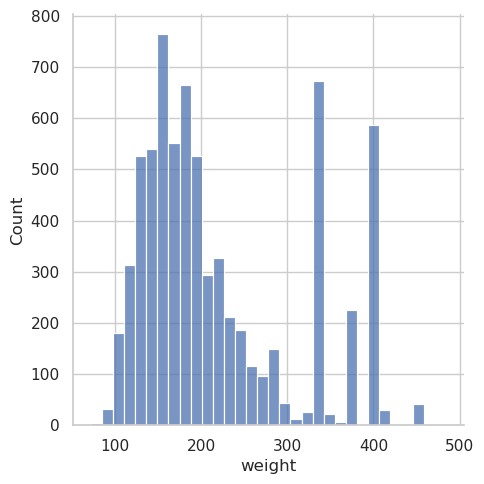

In [51]:
sns.displot(
    data = result_df,
    x = "weight"
)

In [52]:
(
    nhanes_df
    .select_columns("height", "weight", "gender", "diabetes", "general_health_condition")
    .sort_values(
        by=['gender','diabetes','general_health_condition','weight'],
        ascending=True
    )
    .groupby(["gender", "general_health_condition"], dropna=False)
    .apply(lambda x: x.ffill())
).info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7157 entries, 94195.0 to 98317.0
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   height                    7157 non-null   float64
 1   weight                    7157 non-null   float64
 2   gender                    7157 non-null   object 
 3   diabetes                  7157 non-null   int64  
 4   general_health_condition  5797 non-null   object 
dtypes: float64(2), int64(1), object(2)
memory usage: 593.5+ KB


<ipython-input-52-ec04eb6a4992>:3: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  nhanes_df


## Interpolation imputation

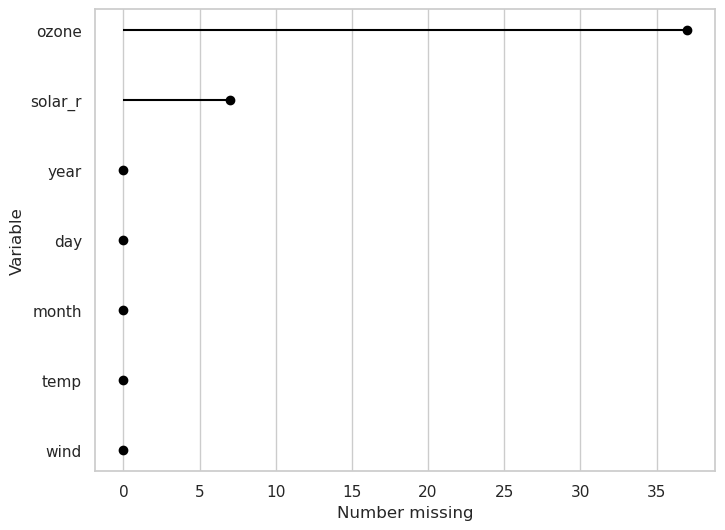

In [53]:
(
    airquality_df.missing.missing_variable_plot()
)

<AxesSubplot: xlabel='date'>

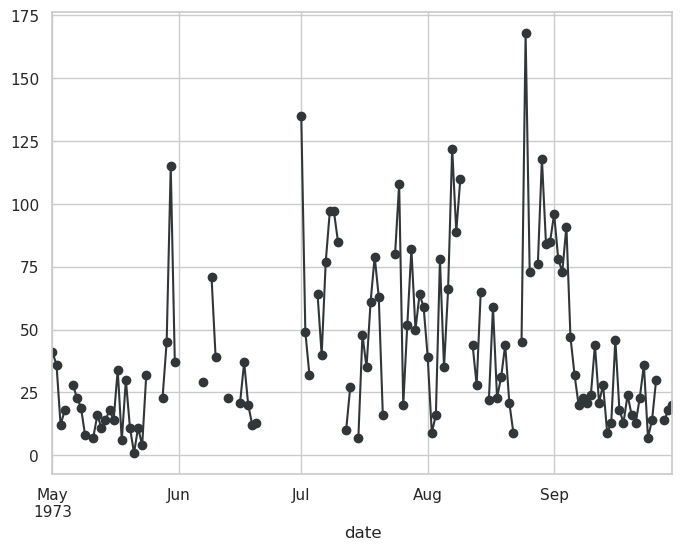

In [54]:
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df : df.ozone.plot(color = "#313638", marker = "o")
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

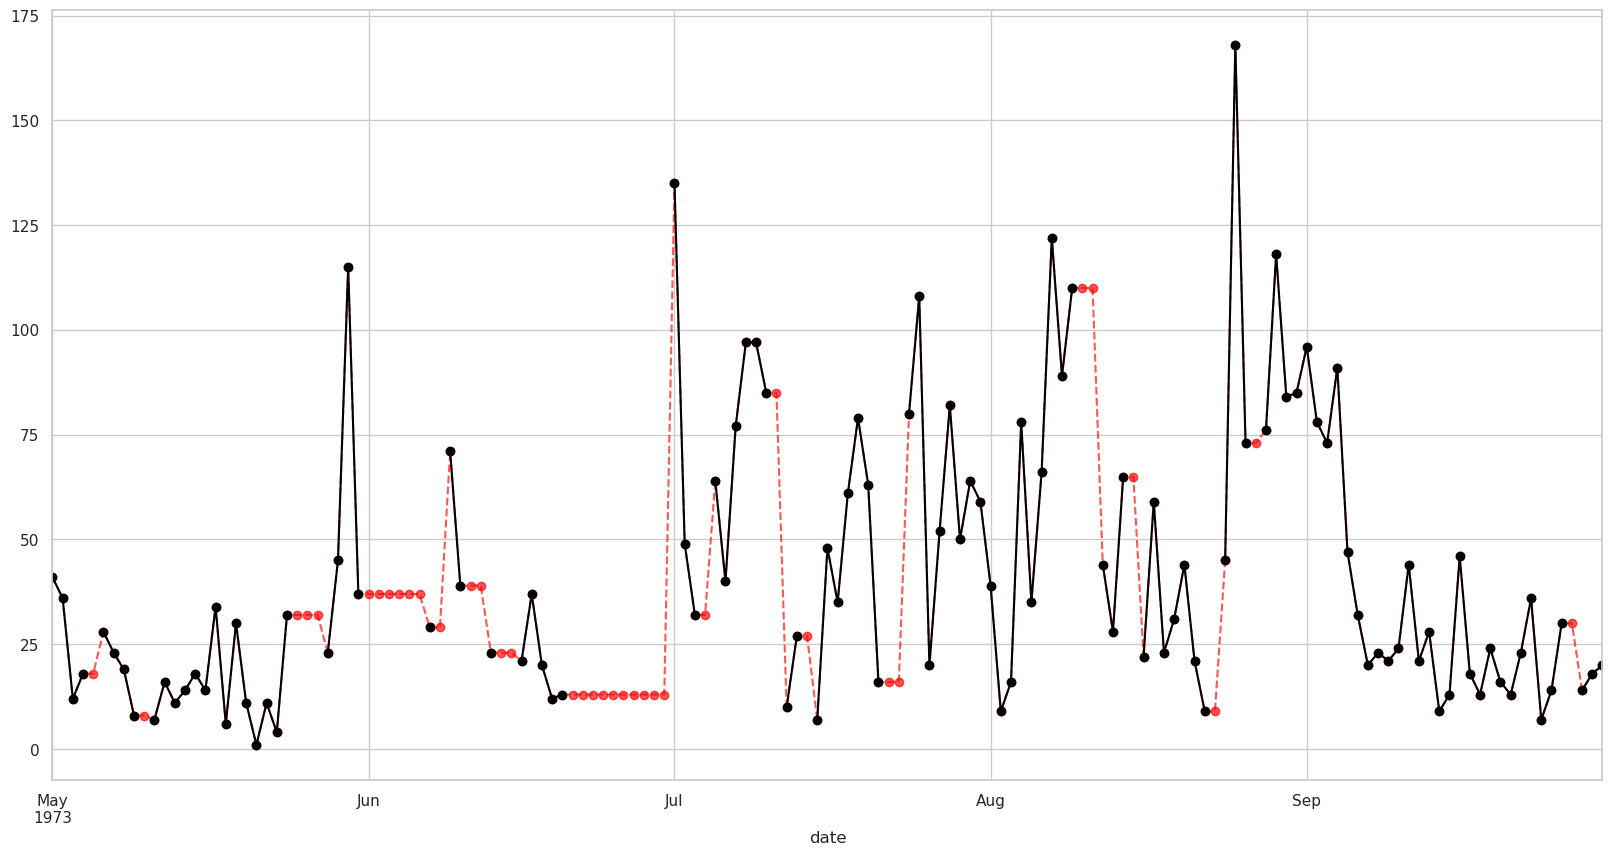

In [55]:
plt.figure(figsize = (20,10))

(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
        df.ozone.ffill().plot(color = "red", marker = "o", alpha = 6/9 , linestyle = "dashed"),
        df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

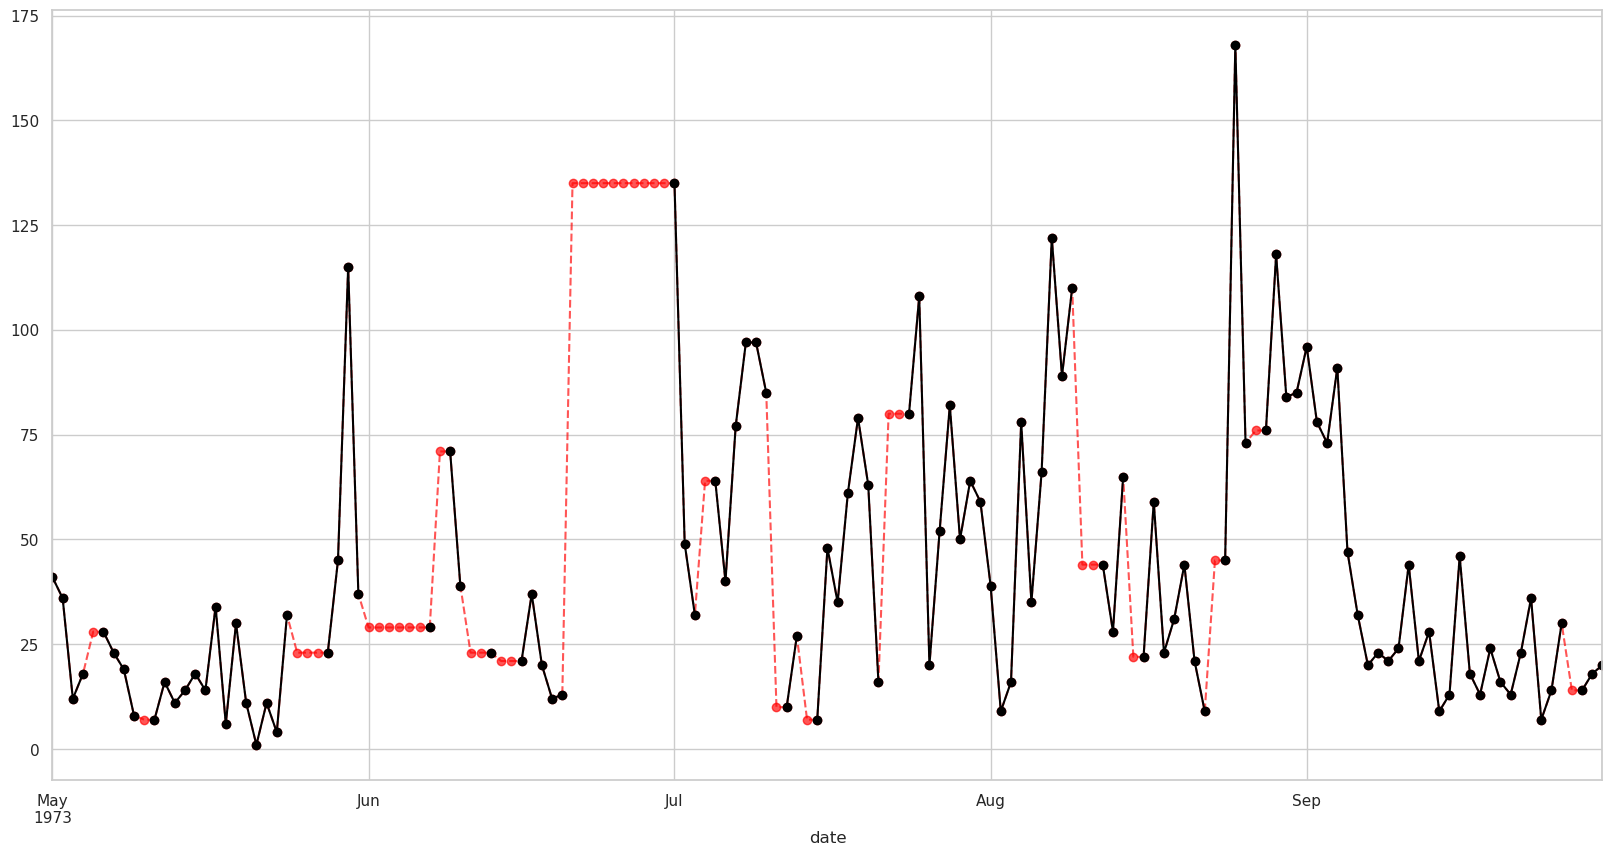

In [56]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.bfill().plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

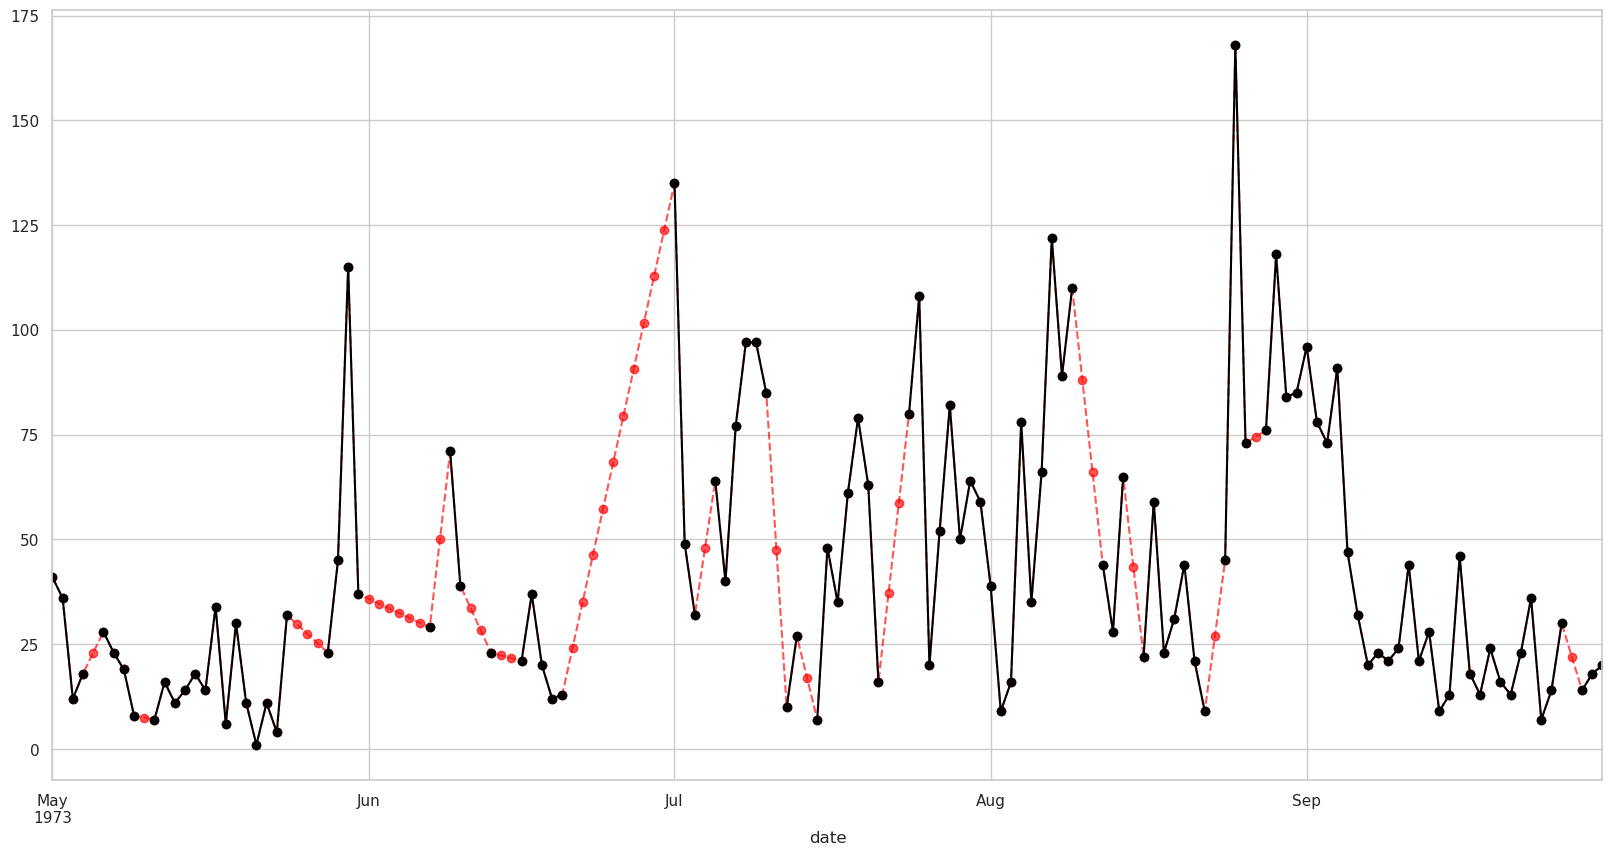

In [57]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "linear").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

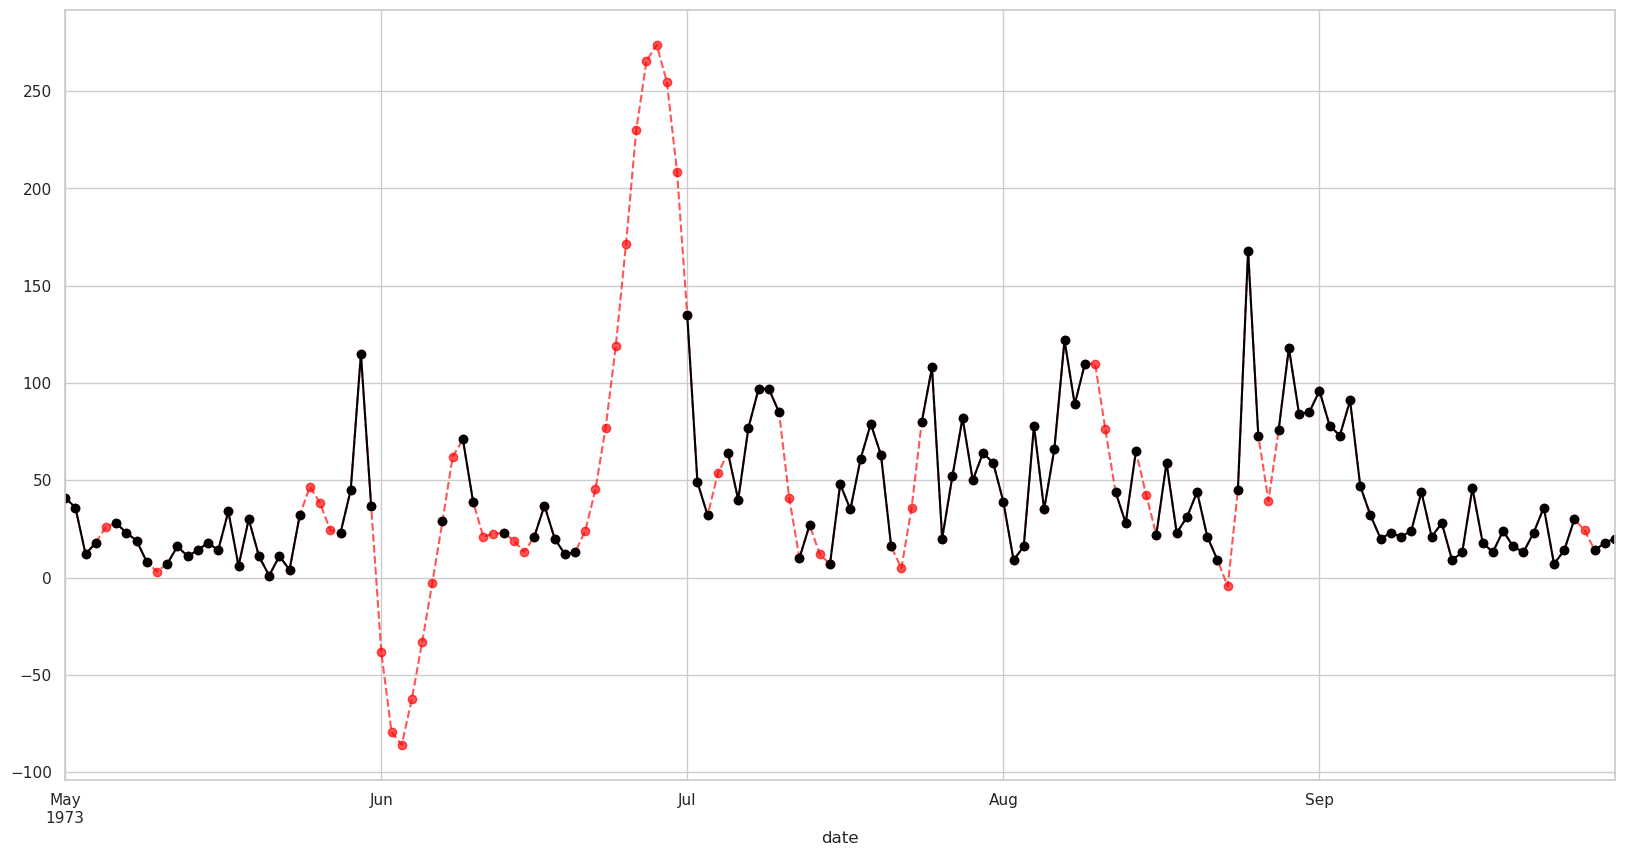

In [58]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "quadratic").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

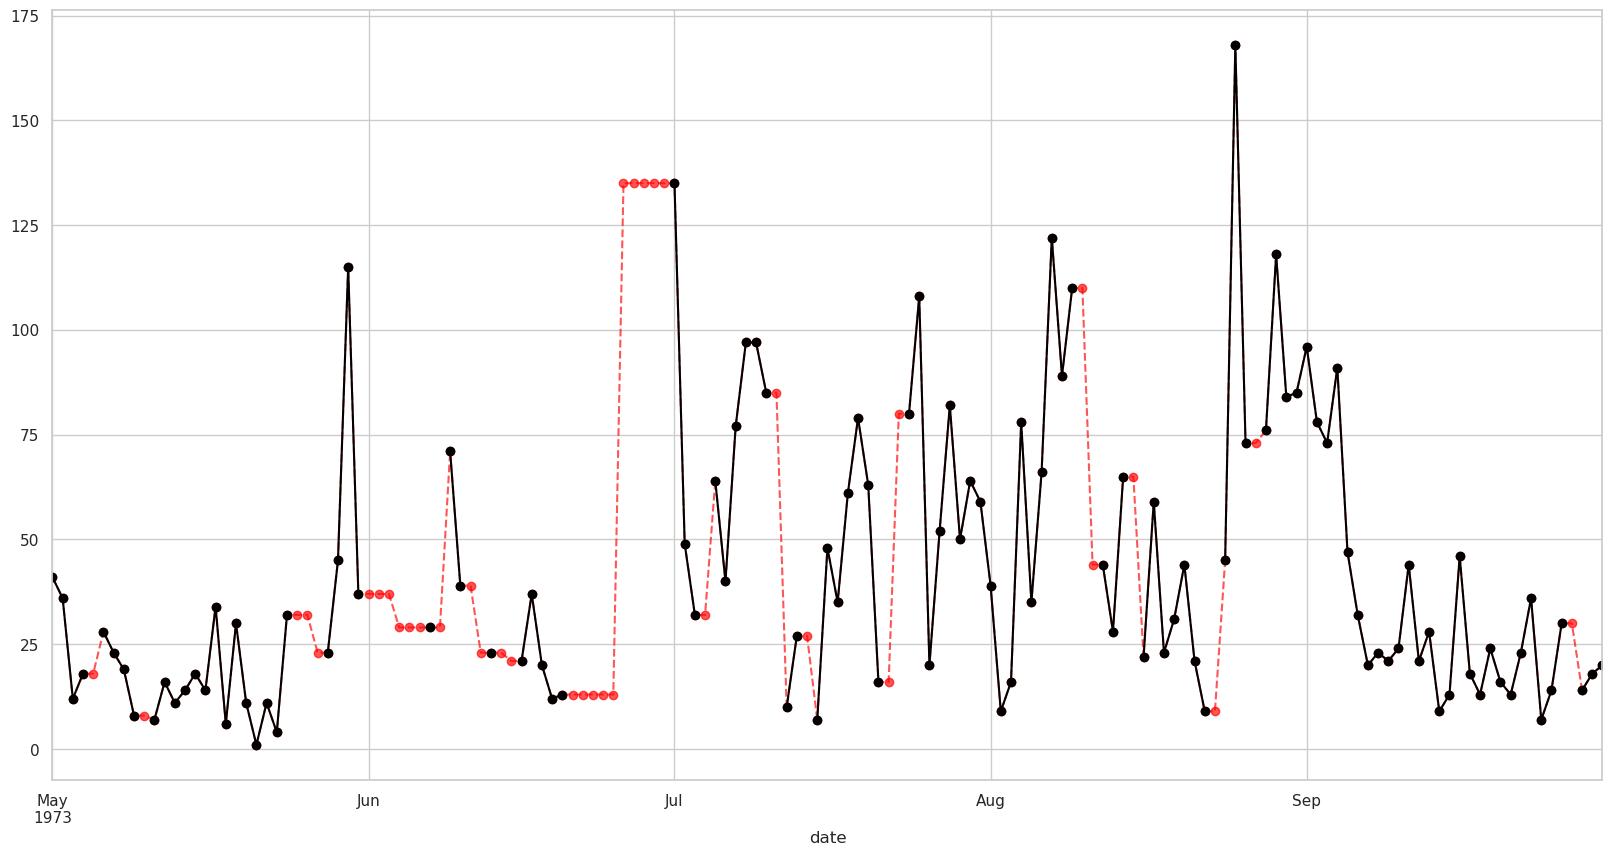

In [59]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "nearest").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

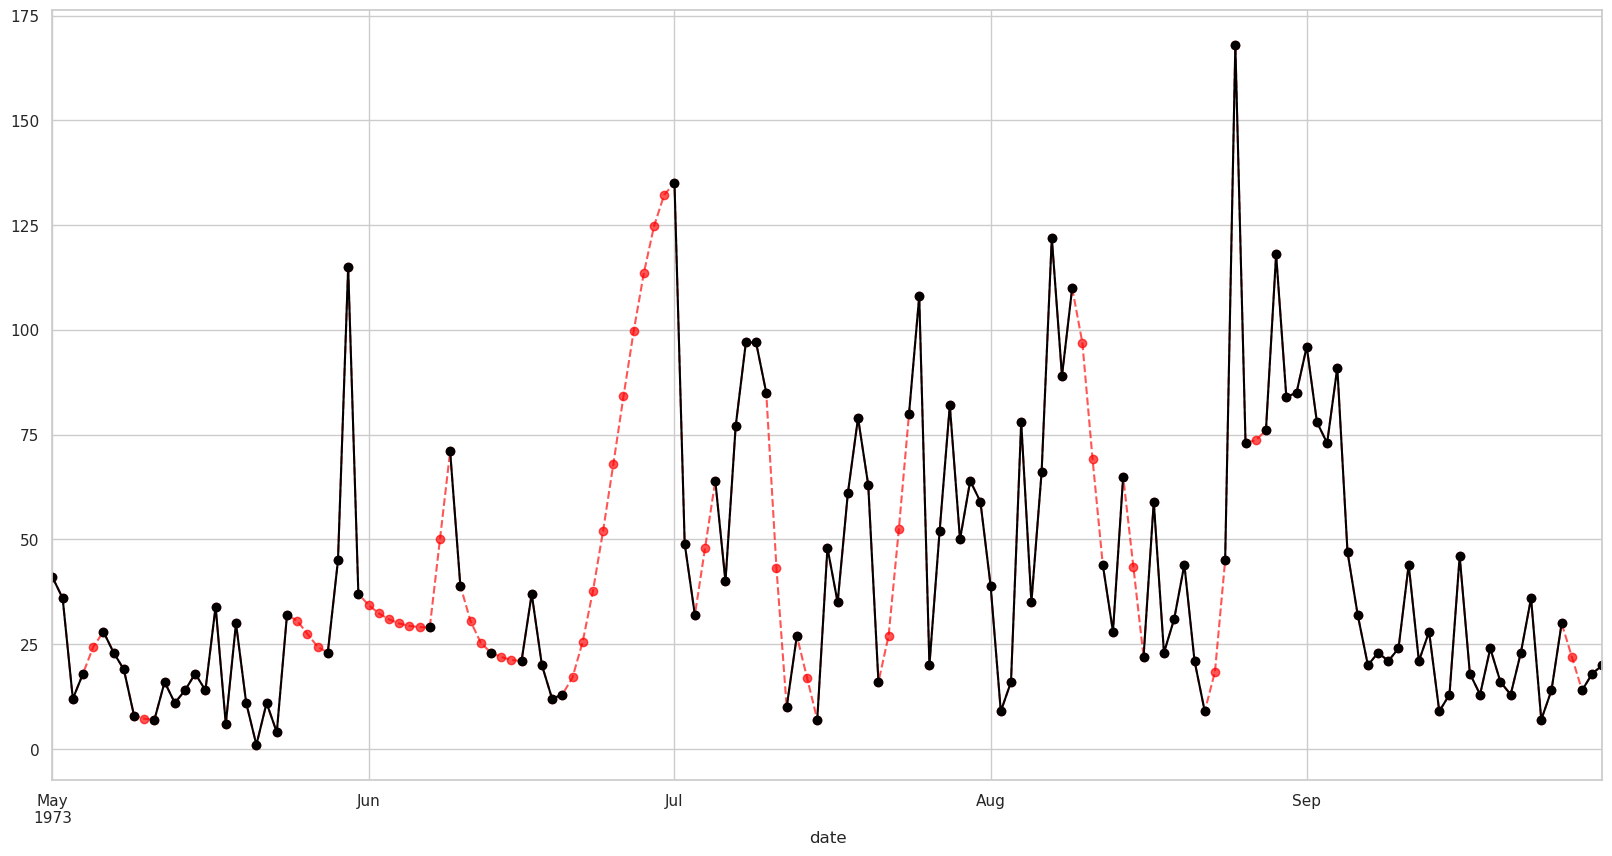

In [60]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "pchip").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

(<AxesSubplot: xlabel='date'>, <AxesSubplot: xlabel='date'>)

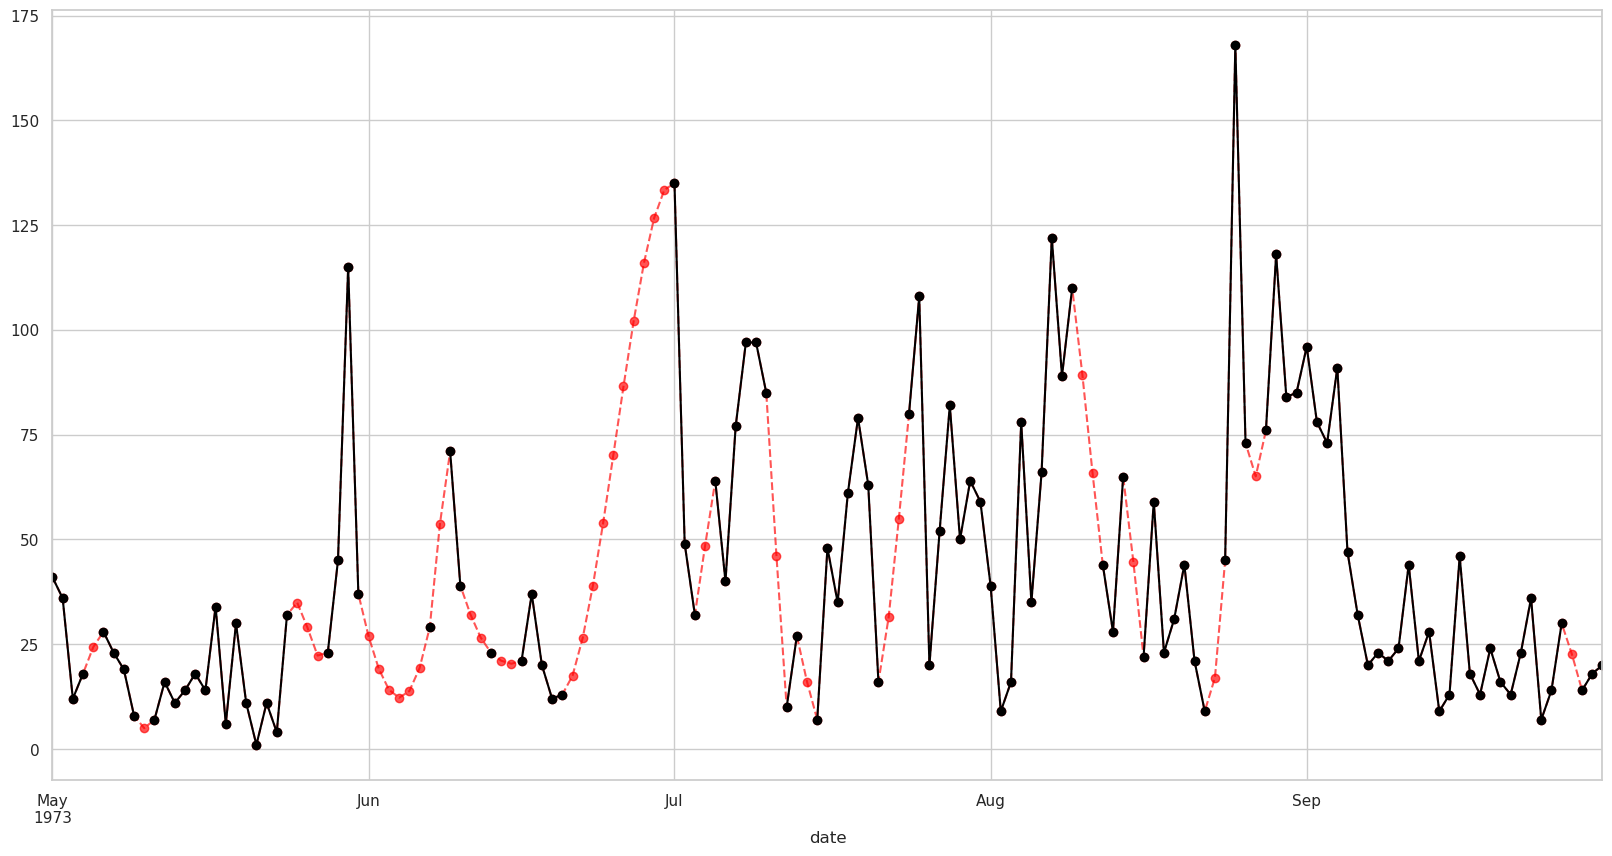

In [61]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "akima").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
        )
    )
)

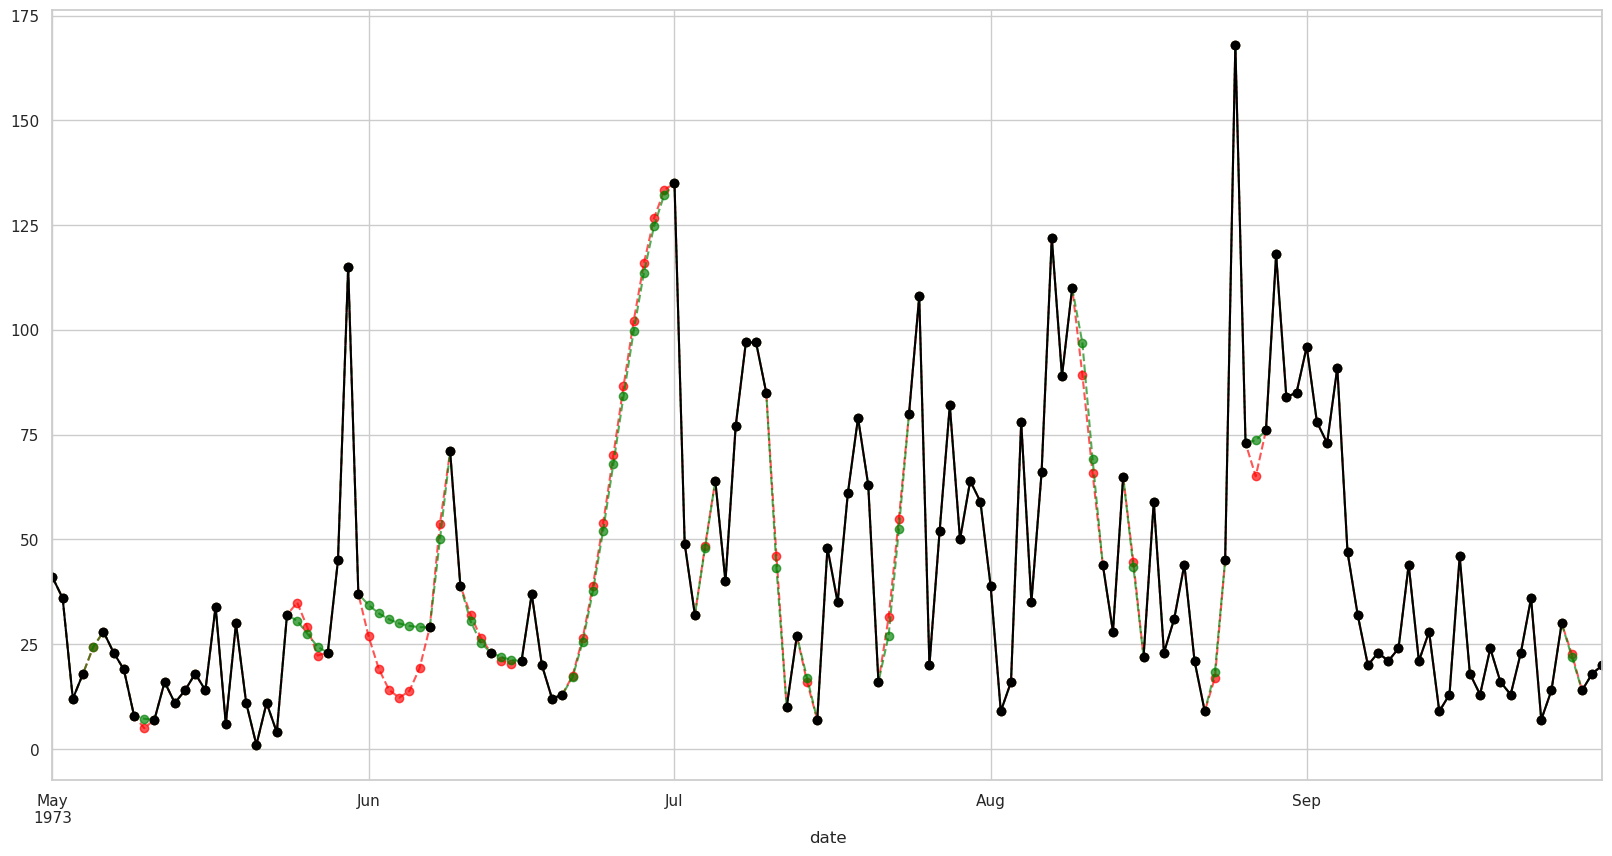

In [62]:
plt.figure(figsize = (20,10))
(
    airquality_df
    .select_columns("ozone")
    .pipe(
        lambda df: (
            df.ozone.interpolate(method = "akima").plot(color = "red", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.interpolate(method = "pchip").plot(color = "green", marker = "o", alpha = 6/9, linestyle = "dashed"),
            df.ozone.plot(color = "black", marker = "o")
            

        )
    )
);

In [63]:
airquality_df["ozone"] = airquality_df.ozone.interpolate(method = "linear")

airquality_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 153 entries, 1973-05-01 to 1973-09-30
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   ozone    153 non-null    float64
 1   solar_r  146 non-null    float64
 2   wind     153 non-null    float64
 3   temp     153 non-null    int64  
 4   month    153 non-null    int64  
 5   day      153 non-null    int64  
 6   year     153 non-null    int64  
dtypes: float64(3), int64(4)
memory usage: 9.6 KB


## Imputation using k-Nearest Neighbors (KNN) algorithm

In [64]:
nhanes_df

height  weight general_health_condition  total_cholesterol  pulse  \
SEQN                                                                          
93705.0     63.0   165.0                     Good              157.0   52.0   
93706.0     68.0   145.0                Very good              148.0   82.0   
93707.0      NaN     NaN                     Good              189.0  100.0   
93709.0     62.0   200.0                      NaN              176.0   74.0   
93711.0     69.0   142.0                Very good              238.0   62.0   
...          ...     ...                      ...                ...    ...   
102949.0    72.0   180.0                Excellent              201.0   96.0   
102953.0    65.0   218.0                  Fair or              182.0   78.0   
102954.0    66.0   150.0                     Good              172.0   78.0   
102955.0     NaN     NaN                Very good              150.0   74.0   
102956.0    69.0   250.0                     Good              163.0   76.0   

          diabetes   age  gender  
SEQN                              
93705.0          0  66.0  Female  
93706.0          0  18.0    Male  
93707.0          0  13.0    Male  
93709.0          0  75.0  Female  
93711.0          0  56.0    Male  
...            ...   ...     ...  
102949.0         0  33.0    Male  
102953.0         0  42.0    Male  
102954.0         0  41.0  Female  
102955.0         0  14.0  Female  
102956.0         0  38.0    Male  

[7157 rows x 8 columns]

In [65]:
nhanes_transformed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0     NaN     NaN              189.0   
93709.0                        NaN     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0     NaN     NaN              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [66]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.copy(deep = True)

nhanes_df_knn.iloc[ : , : ] = knn_imputer.fit_transform(nhanes_transformed_df).round()
nhanes_df_knn

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                            
93705.0                        2.0     0.0    63.0   165.0              157.0   
93706.0                        4.0     1.0    68.0   145.0              148.0   
93707.0                        2.0     1.0    69.0   130.0              189.0   
93709.0                        2.0     0.0    62.0   200.0              176.0   
93711.0                        4.0     1.0    69.0   142.0              238.0   
...                            ...     ...     ...     ...                ...   
102949.0                       0.0     1.0    72.0   180.0              201.0   
102953.0                       1.0     1.0    65.0   218.0              182.0   
102954.0                       2.0     0.0    66.0   150.0              172.0   
102955.0                       4.0     0.0    71.0   159.0              150.0   
102956.0                       2.0     1.0    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [67]:
nhanes_df_knn.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7157 entries, 93705.0 to 102956.0
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   general_health_condition  7157 non-null   float64
 1   gender                    7157 non-null   float64
 2   height                    7157 non-null   float64
 3   weight                    7157 non-null   float64
 4   total_cholesterol         7157 non-null   float64
 5   pulse                     7157 non-null   float64
 6   diabetes                  7157 non-null   float64
 7   age                       7157 non-null   float64
dtypes: float64(8)
memory usage: 761.3 KB


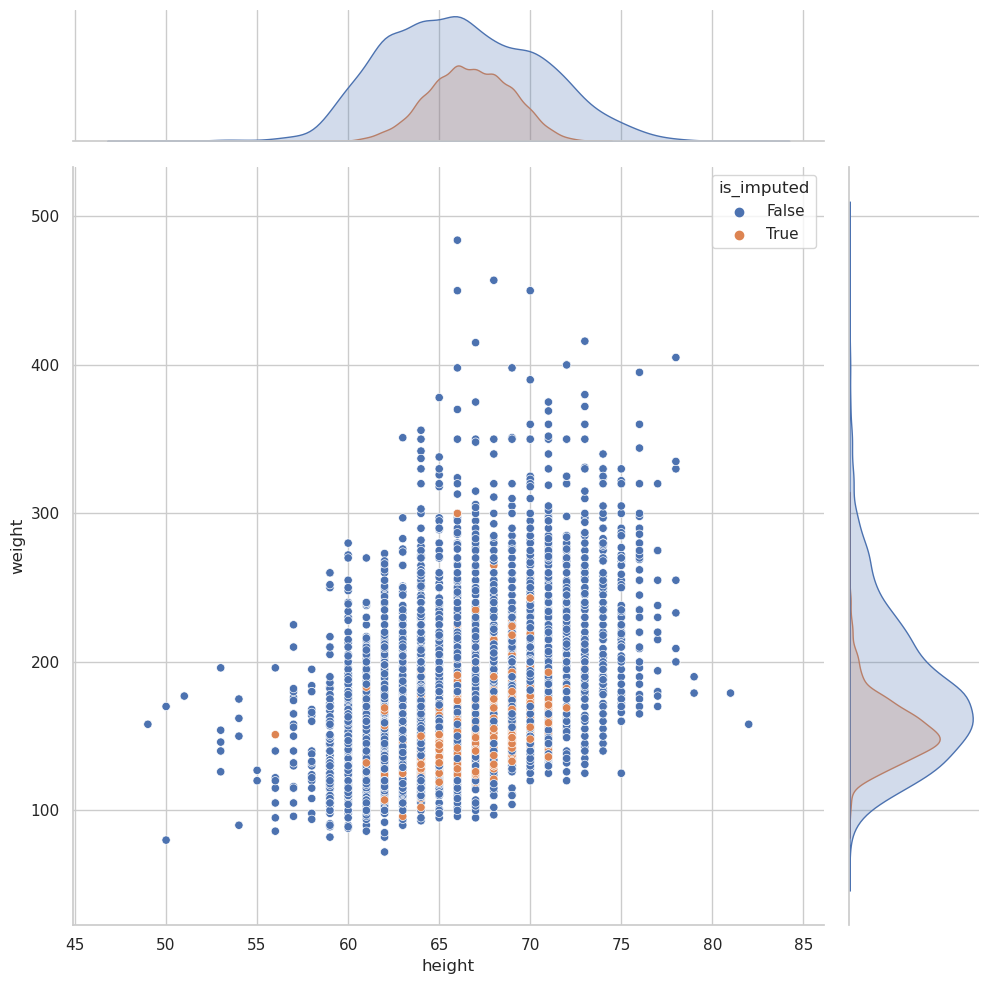

In [68]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix = "_imp", only_missing = True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        height = 10
    )
)

### Sorting by the number of missing variables

In [69]:
knn_imputer = sklearn.impute.KNNImputer()

nhanes_df_knn = nhanes_transformed_df.missing.sort_variables_by_missingness(ascending = True).copy(deep = True)

nhanes_df_knn.iloc[ : , : ] = knn_imputer.fit_transform(nhanes_transformed_df.missing.sort_variables_by_missingness(ascending = True)).round()
nhanes_df_knn

gender  diabetes   age  pulse  total_cholesterol  \
SEQN                                                         
93705.0      0.0       0.0  66.0   52.0              157.0   
93706.0      1.0       0.0  18.0   82.0              148.0   
93707.0      1.0       0.0  13.0  100.0              189.0   
93709.0      0.0       0.0  75.0   74.0              176.0   
93711.0      1.0       0.0  56.0   62.0              238.0   
...          ...       ...   ...    ...                ...   
102949.0     1.0       0.0  33.0   96.0              201.0   
102953.0     1.0       0.0  42.0   78.0              182.0   
102954.0     0.0       0.0  41.0   78.0              172.0   
102955.0     0.0       0.0  14.0   74.0              150.0   
102956.0     1.0       0.0  38.0   76.0              163.0   

          general_health_condition  weight  height  
SEQN                                                
93705.0                        2.0   165.0    63.0  
93706.0                        4.0   145.0    68.0  
93707.0                        2.0   130.0    69.0  
93709.0                        2.0   200.0    62.0  
93711.0                        4.0   142.0    69.0  
...                            ...     ...     ...  
102949.0                       0.0   180.0    72.0  
102953.0                       1.0   218.0    65.0  
102954.0                       2.0   150.0    66.0  
102955.0                       4.0   159.0    71.0  
102956.0                       2.0   250.0    69.0  

[7157 rows x 8 columns]

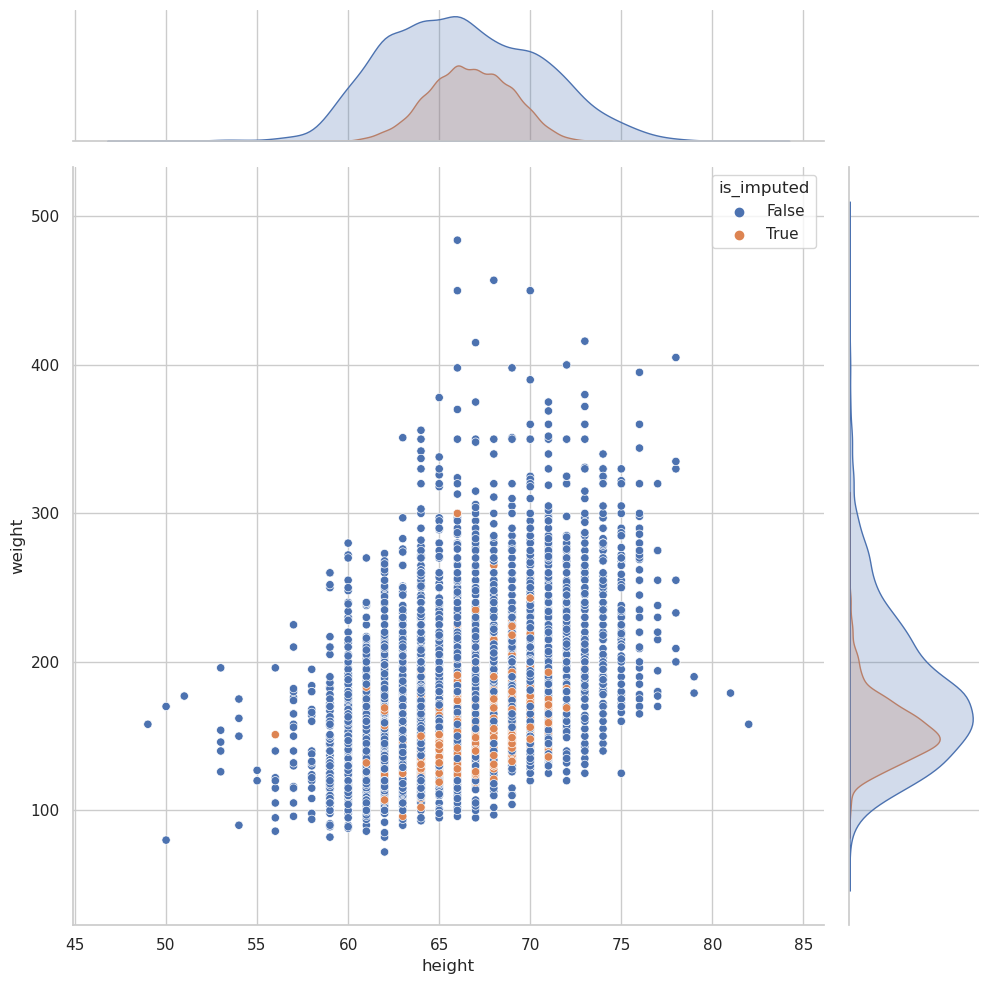

In [70]:
(
    pd.concat(
        [
            nhanes_df_knn,
            nhanes_df.missing.create_shadow_matrix(True, False, suffix = "_imp", only_missing = True)
        ],
        axis = 1
    )
    .missing.scatter_imputation_plot(
        x = "height",
        y = "weight",
        show_marginal = True,
        height = 10
    )
)

## Model-based imputation

In [71]:
nhanes_model_df = (
    nhanes_df
    .select_columns(
        "height", "weight", "gender", "age"
    )
    .sort_values( by = "height")
    .transform_column(
        "weight",
        lambda x : x.ffill(),
        elementwise = False
    )
    .missing.bind_shadow_matrix(
        True, 
        False, 
        suffix = "_imp",
        only_missing = False
    )
)

nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
94940.0     49.0   158.0  Female  80.0       False       False       False   
96508.0     50.0   170.0  Female  46.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
102379.0    51.0   177.0  Female  71.0       False       False       False   
93816.0     53.0   146.0  Female  80.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0     NaN   107.0  Female  14.0        True       False       False   
102926.0     NaN   107.0  Female  15.0        True       False       False   
102941.0     NaN   107.0  Female  14.0        True       False       False   
102945.0     NaN   107.0    Male  15.0        True       False       False   
102955.0     NaN   107.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
94940.0     False  
96508.0     False  
97877.0     False  
102379.0    False  
93816.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

In [72]:
height_ols = (
    nhanes_model_df
    .pipe(
        lambda df: smf.ols("height ~ weight + gender + age", data = df)
    )
    .fit()
)

height_ols 

In [73]:
ols_imputed_values = (
    nhanes_model_df
    .pipe(
        lambda df: df[df.height.isna()]
    )
    .pipe(
        lambda df: height_ols.predict(df).round()
    )
)

ols_imputed_values

SEQN
93707.0     69.0
93719.0     64.0
93733.0     64.0
93736.0     69.0
93737.0     69.0
            ... 
102915.0    63.0
102926.0    63.0
102941.0    63.0
102945.0    68.0
102955.0    63.0
Length: 1669, dtype: float64

In [74]:
nhanes_model_df.loc[nhanes_model_df.height.isna(), ["height"]] = ols_imputed_values
nhanes_model_df

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
94940.0     49.0   158.0  Female  80.0       False       False       False   
96508.0     50.0   170.0  Female  46.0       False       False       False   
97877.0     50.0    80.0  Female  29.0       False       False       False   
102379.0    51.0   177.0  Female  71.0       False       False       False   
93816.0     53.0   146.0  Female  80.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102915.0    63.0   107.0  Female  14.0        True       False       False   
102926.0    63.0   107.0  Female  15.0        True       False       False   
102941.0    63.0   107.0  Female  14.0        True       False       False   
102945.0    68.0   107.0    Male  15.0        True       False       False   
102955.0    63.0   107.0  Female  14.0        True       False       False   

          age_imp  
SEQN               
94940.0     False  
96508.0     False  
97877.0     False  
102379.0    False  
93816.0     False  
...           ...  
102915.0    False  
102926.0    False  
102941.0    False  
102945.0    False  
102955.0    False  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='weight', ylabel='height'>

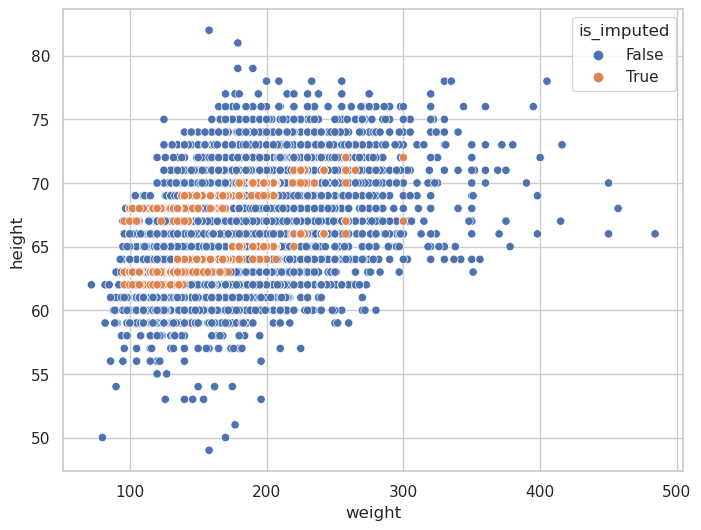

In [75]:
(
    nhanes_model_df
    .missing.scatter_imputation_plot(
        x = "weight",
        y = "height"
    )
)

In [76]:
nhanes_model_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 7157 entries, 94940.0 to 102955.0
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   height      7157 non-null   float64
 1   weight      7157 non-null   float64
 2   gender      7157 non-null   object 
 3   age         7157 non-null   float64
 4   height_imp  7157 non-null   bool   
 5   weight_imp  7157 non-null   bool   
 6   gender_imp  7157 non-null   bool   
 7   age_imp     7157 non-null   bool   
dtypes: bool(4), float64(3), object(1)
memory usage: 307.5+ KB


##### In this instance, model-based imputation is performed for the 'weight' column, with missing values in the 'height' column already imputed. 

In [77]:
nhanes_model_df_2 = (
    nhanes_df
    .select_columns(
        "height", "weight", "gender", "age"
    )
)

nhanes_model_df_2.loc[nhanes_transformed_df2.height.isna(), ["height"]] = ols_imputed_values

nhanes_model_df_2 = (
    nhanes_model_df_2
    .missing.bind_shadow_matrix(
        True,
        False,
        suffix = "_imp"
    )
)    

nhanes_model_df_2




height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
93705.0     63.0   165.0  Female  66.0       False       False       False   
93706.0     68.0   145.0    Male  18.0       False       False       False   
93707.0     69.0     NaN    Male  13.0       False        True       False   
93709.0     62.0   200.0  Female  75.0       False       False       False   
93711.0     69.0   142.0    Male  56.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102949.0    72.0   180.0    Male  33.0       False       False       False   
102953.0    65.0   218.0    Male  42.0       False       False       False   
102954.0    66.0   150.0  Female  41.0       False       False       False   
102955.0    63.0     NaN  Female  14.0       False        True       False   
102956.0    69.0   250.0    Male  38.0       False       False       False   

          age_imp  
SEQN               
93705.0     False  
93706.0     False  
93707.0     False  
93709.0     False  
93711.0     False  
...           ...  
102949.0    False  
102953.0    False  
102954.0    False  
102955.0    False  
102956.0    False  

[7157 rows x 8 columns]

In [78]:
weight_ols = (
    nhanes_model_df_2
    .pipe(
        lambda df: smf.ols("weight ~ height + gender + age", data = df)
    )
    .fit()
)

weight_ols 

In [79]:
ols_imputed_values_weight = (
    nhanes_model_df_2
    .pipe(
        lambda df: df[df.weight.isna()]
    )
    .pipe(
        lambda df: weight_ols.predict(df).round()
    )
)

ols_imputed_values_weight

SEQN
93707.0     186.0
93719.0     162.0
93733.0     161.0
93736.0     186.0
93737.0     185.0
            ...  
102915.0    156.0
102926.0    156.0
102941.0    156.0
102945.0    181.0
102955.0    156.0
Length: 1604, dtype: float64

In [80]:
nhanes_model_df_2.loc[nhanes_model_df_2.weight.isna(), ["weight"]] = ols_imputed_values_weight
nhanes_model_df_2

height  weight  gender   age  height_imp  weight_imp  gender_imp  \
SEQN                                                                         
93705.0     63.0   165.0  Female  66.0       False       False       False   
93706.0     68.0   145.0    Male  18.0       False       False       False   
93707.0     69.0   186.0    Male  13.0       False        True       False   
93709.0     62.0   200.0  Female  75.0       False       False       False   
93711.0     69.0   142.0    Male  56.0       False       False       False   
...          ...     ...     ...   ...         ...         ...         ...   
102949.0    72.0   180.0    Male  33.0       False       False       False   
102953.0    65.0   218.0    Male  42.0       False       False       False   
102954.0    66.0   150.0  Female  41.0       False       False       False   
102955.0    63.0   156.0  Female  14.0       False        True       False   
102956.0    69.0   250.0    Male  38.0       False       False       False   

          age_imp  
SEQN               
93705.0     False  
93706.0     False  
93707.0     False  
93709.0     False  
93711.0     False  
...           ...  
102949.0    False  
102953.0    False  
102954.0    False  
102955.0    False  
102956.0    False  

[7157 rows x 8 columns]

<AxesSubplot: xlabel='weight', ylabel='height'>

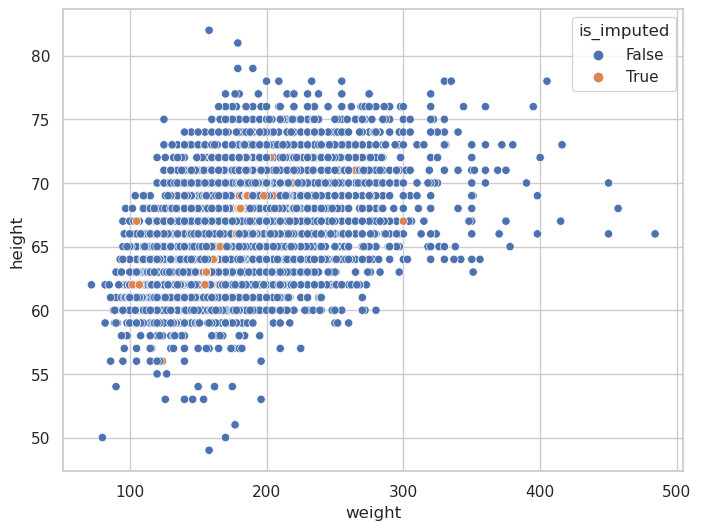

In [81]:
pd.concat(
    [
        nhanes_model_df_2
        .select_columns("height", "weight", "gender", "age"),
        nhanes_df
        .select_columns("height", "weight", "gender", "age")
        .missing.create_shadow_matrix(True, False, suffix = "_imp")
    ],
    axis = 1
).missing.scatter_imputation_plot(x = "weight",y = "height")

## Multiple Imputation by Chained Equations (MICE)

##### Supplementary material: Explanation of MICE method by Numpyninja
##### https://www.numpyninja.com/post/mice-algorithm-to-impute-missing-values-in-a-dataset

<AxesSubplot: xlabel='weight', ylabel='height'>

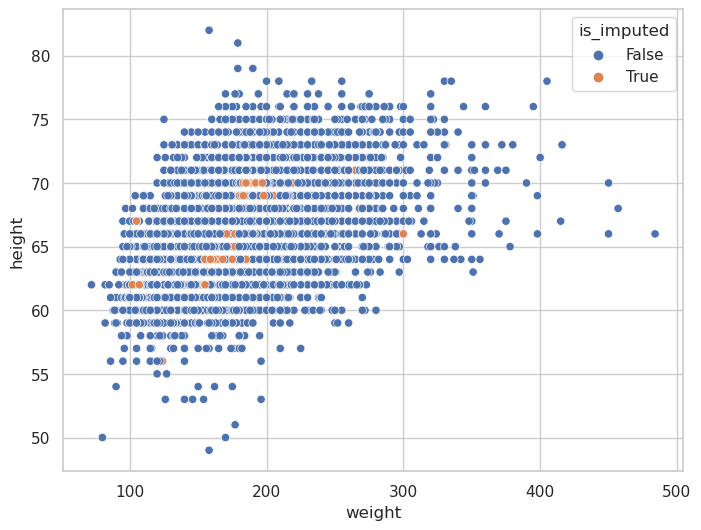

In [82]:
mice_imputer = sklearn.impute.IterativeImputer(
    estimator = BayesianRidge(),
    initial_strategy = "median",
    imputation_order = "ascending"
)

nhanes_mice_df = nhanes_transformed_df.copy( deep = True)

nhanes_mice_df.iloc[:,:] = mice_imputer.fit_transform(nhanes_transformed_df).round()

pd.concat(
    [
        nhanes_mice_df,
        nhanes_df.missing.create_shadow_matrix(True, False, suffix = "_imp")
     ],
     axis = 1
).missing.scatter_imputation_plot(
    x = "weight",
    y = "height"
)


## Inverse transformation of the data

In [83]:
nhanes_imputed_df = nhanes_mice_df.copy(deep = True)

In [84]:
nhanes_imputed_df[categorical_columns] = (
    categorical_transformer
    .named_transformers_
    .ordinalencoder
    .inverse_transform(
        X = nhanes_mice_df[categorical_columns]
    )
)
nhanes_imputed_df

general_health_condition  gender  height  weight  total_cholesterol  \
SEQN                                                                           
93705.0                      Good  Female    63.0   165.0              157.0   
93706.0                 Very good    Male    68.0   145.0              148.0   
93707.0                      Good    Male    70.0   200.0              189.0   
93709.0                      Good  Female    62.0   200.0              176.0   
93711.0                 Very good    Male    69.0   142.0              238.0   
...                           ...     ...     ...     ...                ...   
102949.0                Excellent    Male    72.0   180.0              201.0   
102953.0                  Fair or    Male    65.0   218.0              182.0   
102954.0                     Good  Female    66.0   150.0              172.0   
102955.0                Very good  Female    64.0   159.0              150.0   
102956.0                     Good    Male    69.0   250.0              163.0   

          pulse  diabetes   age  
SEQN                             
93705.0    52.0       0.0  66.0  
93706.0    82.0       0.0  18.0  
93707.0   100.0       0.0  13.0  
93709.0    74.0       0.0  75.0  
93711.0    62.0       0.0  56.0  
...         ...       ...   ...  
102949.0   96.0       0.0  33.0  
102953.0   78.0       0.0  42.0  
102954.0   78.0       0.0  41.0  
102955.0   74.0       0.0  14.0  
102956.0   76.0       0.0  38.0  

[7157 rows x 8 columns]

In [85]:
nhanes_df.general_health_condition.value_counts()

Good         2383
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [86]:
nhanes_imputed_df.general_health_condition.value_counts()

Good         3743
Very good    1503
Fair or      1130
Excellent     612
Poor?         169
Name: general_health_condition, dtype: int64

In [87]:
nhanes_imputed_df.missing.number_missing()

0

## Session information

In [88]:
session_info.show()